In [28]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math
from matplotlib.lines import Line2D

# Computo de perturbaciones con CLASS y grilla

## Código robado de Julien 
(no lo uso para nada, pero sirve como ejemplo)

In [20]:
#############################################
#
# value of k that we want to follow in [1/Mpc]
#
k = 0.5  # 1/Mpc
#
# Cosmological parameters and other CLASS parameters
#
common_settings = {# we need to set the output field to something although
                   # the really releveant outpout here will be set with 'k_output_values'
                   'output':'mPk',
                   # value of k we want to polot in [1/Mpc]
                   'k_output_values':k,
                   # LambdaCDM parameters
                   'h':0.78,
                   'Omega_b':0.05,
                   'Omega_cdm':0.25,
                   'A_s':2.100549e-09 ,
                   'n_s':0.9660499,
                   'tau_reio':0.05430842,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.2454,
                   # other options and settings
                   'compute damping scale':'yes', # needed to output the time of damping scale crossing
                   'gauge':'newtonian'}
##############
#
# call CLASS
#
M = Class()
M.set(common_settings)
M.compute()
#
# load perturbations
#
all_k = M.get_perturbations()  # this potentially constains scalars/tensors and all k values
print (all_k['scalar'][0].keys())
#
one_k = all_k['scalar'][0]     # this contains only the scalar perturbations for the requested k values
#
tau = one_k['tau [Mpc]']
Theta0 = 0.25*one_k['delta_g']
phi = one_k['phi']
psi = one_k['psi']
theta_b = one_k['theta_b']
a = one_k['a']
# compute related quantitites
R = 3./4.*M.Omega_b()/M.Omega_g()*a    # R = 3/4 * (rho_b/rho_gamma)
zero_point = -(1.+R)*psi               # zero point of oscillations: -(1.+R)*psi
#
# get Theta0 oscillation amplitude (for vertical scale of plot)
#
Theta0_amp = max(Theta0.max(),-Theta0.min())
#
# get the time of decoupling
#
quantities = M.get_current_derived_parameters(['tau_rec'])
# print times.viewkeys()
tau_rec = quantities['tau_rec']
#
# use table of background quantitites to find the time of
# Hubble crossing (k / (aH)= 2 pi), sound horizon crossing (k * rs = 2pi)
#
background = M.get_background() # load background table
#print background.viewkeys()
#
background_tau = background['conf. time [Mpc]'] # read confromal times in background table
background_z = background['z'] # read redshift
background_k_over_aH = k/background['H [1/Mpc]']*(1.+background['z']) # read k/aH = k(1+z)/H
background_k_rs = k * background['comov.snd.hrz.'] # read k * rs
background_rho_m_over_r =\
    (background['(.)rho_b']+background['(.)rho_cdm'])\
    /(background['(.)rho_g']+background['(.)rho_ur']) # read rho_r / rho_m (to find time of equality)
#
# define interpolation functions; we want the value of tau when the argument is equal to 2pi (or 1 for equality)
#
tau_at_k_over_aH = interp1d(background_k_over_aH,background_tau)
tau_at_k_rs = interp1d(background_k_rs,background_tau)
tau_at_rho_m_over_r = interp1d(background_rho_m_over_r,background_tau)
#
# finally get these times
#
tau_Hubble = tau_at_k_over_aH(2.*math.pi)
tau_s = tau_at_k_rs(2.*math.pi)
tau_eq = tau_at_rho_m_over_r(1.)
#
#################
#
# start plotting
#
#################
#


dict_keys(['tau [Mpc]', 'a', 'delta_g', 'theta_g', 'shear_g', 'pol0_g', 'pol1_g', 'pol2_g', 'delta_b', 'delta_prime_b', 'theta_b', 'psi', 'phi', 'delta_ur', 'theta_ur', 'shear_ur', 'delta_cdm', 'theta_cdm', 'delta_prime_cdm'])


In [21]:
#get omega radiation
omega_r = M.Omega_r()
print(omega_r)

6.874730684726034e-05


## Funciones

In [29]:
#hago funcion para obtener un objeto con mis vectores de interés (delta_cdm, a y tau)
import pandas as pd

def get_vects_from_perturbations(dicc=all_k['scalar'][0]):
  """
  Extracts 'delta_cdm', 'a', and 'tau [Mpc]' vectors from the perturbations dictionary.

  Args:
    dicc: The perturbations dictionary (default: all_k['scalar'][0]).

  Returns:
    A Pandas DataFrame containing the desired vectors.
  """
  # Extract the vectors from the dictionary
  delta_cdm = dicc['delta_cdm']
  delta_b = dicc['delta_b']
  a = dicc['a']
  tau = dicc['tau [Mpc]']

  # Create df
  df = pd.DataFrame({'tau [Mpc]': tau, 'a': a, 'delta_cdm': delta_cdm, 'delta_b': delta_b})

  return df

#funcoin para obtener sigma8
def get_sigma8(M=M):
  """
  Extracts the current value of sigma8 from the perturbations dictionary.

  Args:
    dicc: The perturbations dictionary (default: all_k['scalar'][0]).

  Returns:
    The current value of sigma8.
  """

  _sigma= M.get_current_derived_parameters(['sigma8'])
  return _sigma['sigma8']


def delta_prima(df_results):
    """
    Calcula la derivada numérica de 'delta_cdm' con respecto a 'a' en cada fila del DataFrame.

    Args:
        df_results (pd.DataFrame): DataFrame con columnas 'a' y 'delta_cdm', donde cada celda contiene un vector.

    Returns:
        pd.Series: Una serie con los vectores de la derivada para cada fila.
    """
    def calculate_gradient(row):
        if len(row["delta_cdm"]) == len(row["a"]):
            return np.gradient(row["delta_cdm"], row["a"])
        else:
            # send warning if not
            print(f"Warning: Length mismatch in row {row.name}. Returning NaNs.")
            #print len of each rows
            print(f"Length of 'a': {len(row['a'])}")
            print(f"Length of 'delta_cdm': {len(row['delta_cdm'])}")
            return [np.nan] * len(row["a"]) #return nan en el caso patologico de mismatch lenghts

    return df_results.apply(calculate_gradient, axis=1)

def common_settings(k=0.01, omega_cdm=.25, A_s=2e-9, h=0.68): 
  """
  Set common settings for the CLASS simulation.
  Esto hace basicamente lo mismo que el diccionario de common_settings del principio (el de Julien),
    pero con los valores de k, omega_cdm, A_s y h como argumentos.

  Args:
    k (float): Value of k for the simulation.
    omega_cdm (float): Omega_cdm value for the simulation.
    A_s (float): A_s value for the simulation.
    h (float): h value for the simulation.

  Returns:
    A dictionary containing the common settings for the simulation.
  """
  _common_settings = {
    'output': 'mPk',
    'k_output_values': k,
    'h': h,
    'Omega_b': 0.3-omega_cdm,
    'Omega_cdm': omega_cdm,
    'A_s': A_s,
    'n_s': 0.9660499,
    'tau_reio': 0.05430842,
    'YHe': 0.2454,
    'compute damping scale': 'yes',
    'gauge': 'newtonian'
    }
  M = Class()
  M.set(_common_settings)
  M.compute()
  return M

def get_df_from_M(M): #tal vez lo modifique para obtener las derivadas directamente acá. sería útil para la grilla.
  """
  Extracts 'delta_cdm', 'a', and 'tau [Mpc]' vectors from the perturbations.
  It does not extract inputs of the perturbation dictionary (like A_s, h, omega...)

  Args:
    class: M - (example: common_settings(k=1)).

  Returns:
    A Pandas DataFrame containing the desired vectors.
  """
  all_k = M.get_perturbations()
  one_k = all_k['scalar'][0]
  a = one_k['a']
  tau = one_k['tau [Mpc]']
  delta_cdm = one_k['delta_cdm']
  delta_b = one_k['delta_b']
  df = pd.DataFrame({'tau [Mpc]': tau, 'a': a, 'delta_cdm': delta_cdm, 'delta_b': delta_b})
  return df



## Computar parámetros para grilla:
Prueba de armar "grilla" con barridos en $h$, $A_s$ y $\Omega_{cdm}$

In [23]:
import numpy as np
from classy import Class
import pandas as pd
from itertools import product
from tqdm import tqdm

# rango de valores para cada parámetro
omega_cdm_values = np.arange(0.10, 0.14 + 0.03, 0.03)
A_s_values = np.arange(1.9e-09, 2.3e-09 + 0.3e-09, 0.3e-09)
h_values = np.arange(0.65, 0.80 + 0.03, 0.03)
#si quisiera barrer k generar otro igual y agregarlo a product()


results = []

k = 0.01  # 1/Mpc

# Arrancamos a iterar
for omega_cdm, A_s, h in tqdm(product(omega_cdm_values, A_s_values, h_values)):

    M= common_settings(k, omega_cdm, A_s, h)
    sigma8 = get_sigma8(M)

    # perturbaciones
    all_k = M.get_perturbations()
    one_k = all_k['scalar'][0]
    a = one_k['a']
    tau = one_k['tau [Mpc]']
    delta_cdm = one_k['delta_cdm']
    delta_b = one_k['delta_b']

    # guardar results
    result = {
        'omega_cdm': omega_cdm,
        'A_s': A_s,
        'h': h,
        'sigma8': sigma8,
        'a': np.array(a),
        'tau': np.array(tau),
        'delta_cdm': np.array(delta_cdm),
        'delta_b': np.array(delta_b),
    }

    results.append(result)

    # liberar memoria
    M.struct_cleanup()

# crear df
df_results = pd.DataFrame(results)
#guardo df_results
# df_results.to_csv('results.csv', index=False)


63it [00:51,  1.22it/s]


In [24]:
#agrego a df_results delta_prima:
df_results['delta_prima'] = delta_prima(df_results)
#print every len of df_results['delta_cmd'] and df_results['a'] row by row:
for i in range(len(df_results)):
    if len(df_results['delta_prima'][i]) != len(df_results['a'][i]):
        print('Error en fila', i)

    # print(len(df_results['delta_prima'][i]), len(df_results['a'][i]))

In [25]:
df_results.head()

,omega_cdm,A_s,h,sigma8,a,tau,delta_cdm,delta_b,delta_prima
0,0.1,1.900000e-09,0.65,0.233007,"[1.545026885348643e-05, 1.5450271711483482e-05...","[7.080073921723204, 7.080075216586296, 7.08007...","[-0.9100901655126561, -0.9100901670426575, -0....","[-0.9100901655125343, -0.910090167042414, -0.9...","[-535.3404607678812, -535.3405151367188, -535...."
1,0.1,1.900000e-09,0.68,0.241010,"[1.5483680625294583e-05, 1.5483683486754817e-0...","[7.087633541534302, 7.087634835168915, 7.08763...","[-0.9108751577969956, -0.9108751593693135, -0....","[-0.910875157796874, -0.9108751593690705, -0.9...","[-549.4809690142795, -549.4810180664062, -549...."
2,0.1,1.900000e-09,0.71,0.248938,"[1.551867497333083e-05, 1.551867783841921e-05,...","[7.0955335399615835, 7.095534832315618, 7.0955...","[-0.911707596676841, -0.9117075982854811, -0.9...","[-0.9117075966767199, -0.9117075982852388, -0....","[-561.4626488340132, -561.4627685546875, -561...."
3,0.1,1.900000e-09,0.74,0.256800,"[1.5555261848852828e-05, 1.555526471773546e-05...","[7.1037737669892635, 7.10377505801105, 7.10377...","[-0.9125891589783791, -0.9125891606163111, -0....","[-0.9125891589782583, -0.9125891606160694, -0....","[-570.9302967127285, -570.9303283691406, -570...."
4,0.1,1.900000e-09,0.77,0.264593,"[1.5593451624311724e-05, 1.5593454497155966e-0...","[7.1123540506078795, 7.112355340246225, 7.1123...","[-0.913521612143245, -0.9135216138023549, -0.9...","[-0.9135216121431244, -0.9135216138021137, -0....","[-577.5147239514727, -577.5148010253906, -577...."


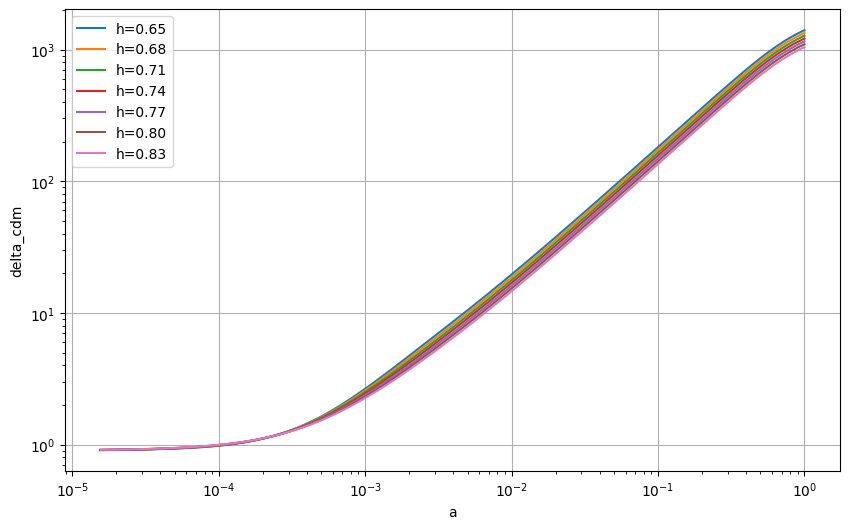

In [26]:
#plot delta_cdm vs a for diferents values of h but same omega_cdm and A_s
import matplotlib.pyplot as plt
def plot_delta_cdm_vs_a(df_results, omega_cdm, A_s):
    """
    Plots delta_cdm vs a for different values of h but same omega_cdm and A_s.

    Args:
        df_results (pd.DataFrame): DataFrame with the results.
        omega_cdm (float): Omega_cdm value to filter the DataFrame.
        A_s (float): A_s value to filter the DataFrame.
    """
    filtered_df = df_results[(df_results['omega_cdm'] == omega_cdm) & (df_results['A_s'] == A_s)]

    plt.figure(figsize=(10, 6))
    for h in filtered_df['h'].unique():
        subset = filtered_df[filtered_df['h'] == h]
        plt.plot(subset['a'].values[0], -subset['delta_cdm'].values[0], label=f'h={h:.2f}')

    plt.xlabel('a')
    plt.ylabel('delta_cdm')
    #logscale in y and x
    plt.xscale('log')
    plt.yscale('log')
    # plt.title(f'delta_cdm vs a for omega_cdm={omega_cdm}, A_s={A_s}')
    plt.legend()
    plt.grid()
    plt.show()

plot_delta_cdm_vs_a(df_results, omega_cdm=df_results['omega_cdm'].iloc[0], A_s=df_results['A_s'].iloc[0])

## Plots

### Plot delta y delta prima para $k=[1, 0.1, 0.01, 0.001]$

/tmp/ipykernel_13526/3474644229.py:37: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[0].set_ylim(-4)


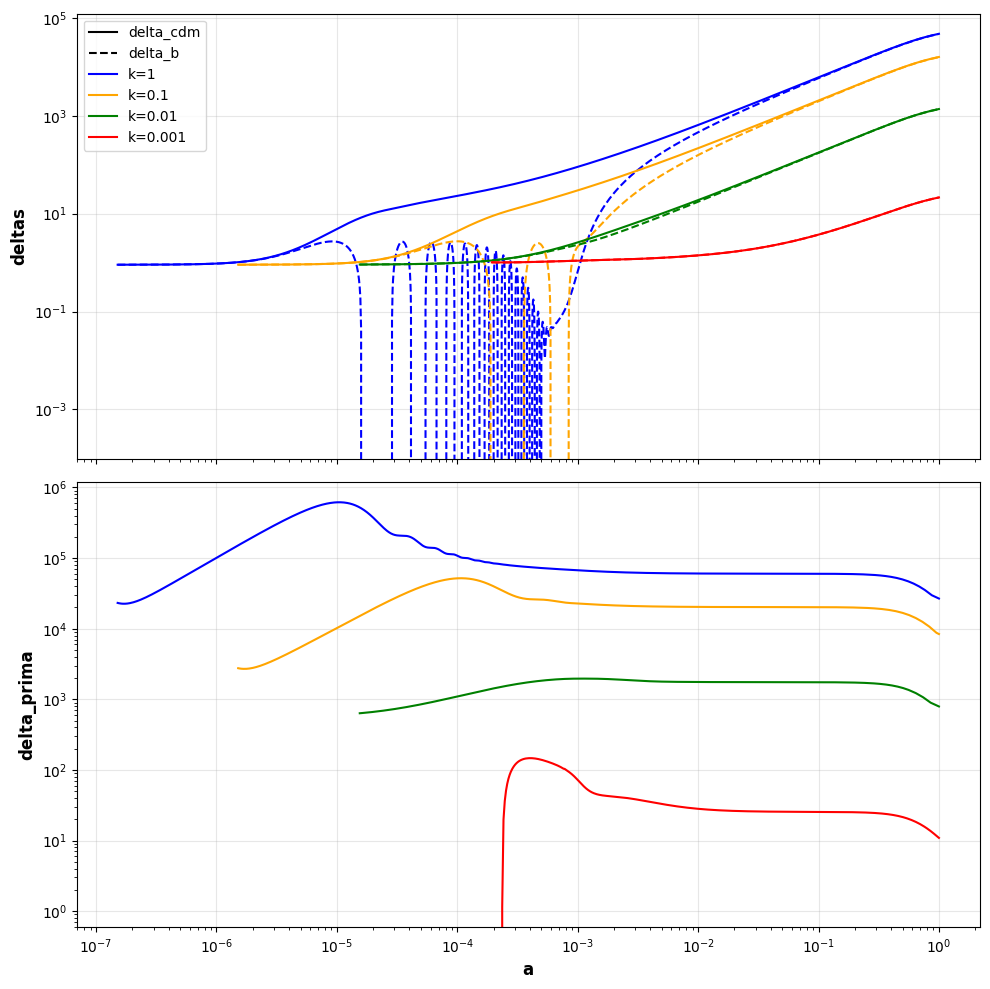

In [27]:
ks = [1, 0.1, 0.01, 0.001]
colors = ['blue', 'orange', 'green', 'red']
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
#legends elements
line_style_elements = [
    Line2D([0], [0], color='black', linestyle='-', label='delta_cdm'),
    Line2D([0], [0], color='black', linestyle='--', label='delta_b')
]
color_elements = []

for i, k in enumerate(ks):
    M = common_settings(k)
    df = get_df_from_M(M)
    delta_prima = list(np.gradient(df['delta_cdm'], df['a']))
    df['delta_prima'] = delta_prima
    color = colors[i]

    axs[0].plot(df['a'], -df['delta_cdm'], linestyle='-', color=color)
    axs[0].plot(df['a'], -df['delta_b'], linestyle='--', color=color)

    
    axs[1].plot(df['a'], -df['delta_prima'], color=color)

    # append color legends
    color_elements.append(Line2D([0], [0], color=color, linestyle='-', label=f'k={k}'))

# Configuración de escalas y etiquetas
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[0].set_ylabel('deltas', fontweight='bold', fontsize=12)
axs[1].set_xlabel('a', fontweight='bold', fontsize=12)
axs[1].set_ylabel('delta_prima', fontweight='bold', fontsize=12)
axs[0].grid(alpha=0.3)
axs[1].grid(alpha=0.3)
axs[0].set_ylim(-4)

# Combinar ambas leyendas en axs[0]
axs[0].legend(handles=line_style_elements + color_elements)

plt.tight_layout()
plt.show()


# Comparación con código de Luca

Para comparar hay que usar modos sub-horizont.

In [4]:
import emcee  # Library for implementing the MCMC method
import corner  # Library for plotting figures with contours and pyramids.
from scipy.integrate import simpson
from scipy.integrate import solve_ivp
import numpy as np
from classy import Class
#import interpolate
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar in loops


### Funciones pedro

In [5]:
#hago funcion para obtener un objeto con mis vectores de interés (delta_cdm, a y tau)
import pandas as pd

#funcoin para obtener sigma8
def get_sigma8(M):
  """
  Extracts the current value of sigma8 from the perturbations dictionary.

  Args:
    dicc: The perturbations dictionary (default: all_k['scalar'][0]).

  Returns:
    The current value of sigma8.
  """

  _sigma= M.get_current_derived_parameters(['sigma8'])
  return _sigma['sigma8']


def delta_prima(df_results):
    """
    Calcula la derivada numérica de 'delta_cdm' con respecto a 'a' en cada fila del DataFrame.

    Args:
        df_results (pd.DataFrame): DataFrame con columnas 'a' y 'delta_cdm', donde cada celda contiene un vector.

    Returns:
        pd.Series: Una serie con los vectores de la derivada para cada fila.
    """
    def calculate_gradient(row):
        if len(row["delta_cdm"]) == len(row["a"]):
            return np.gradient(row["delta_cdm"], row["a"])
        else:
            # send warning if not
            print(f"Warning: Length mismatch in row {row.name}. Returning NaNs.")
            #print len of each rows
            print(f"Length of 'a': {len(row['a'])}")
            print(f"Length of 'delta_cdm': {len(row['delta_cdm'])}")
            return [np.nan] * len(row["a"]) #return nan en el caso patologico de mismatch lenghts

    return df_results.apply(calculate_gradient, axis=1)

def common_settings(k=0.01, omega_cdm=.25, A_s=2e-9, h=0.68): 
  """
  Set common settings for the CLASS simulation.
  Esto hace basicamente lo mismo que el diccionario de common_settings del principio (el de Julien),
    pero con los valores de k, omega_cdm, A_s y h como argumentos.

  Args:
    k (float): Value of k for the simulation.
    omega_cdm (float): Omega_cdm value for the simulation.
    A_s (float): A_s value for the simulation.
    h (float): h value for the simulation.

  Returns:
    A dictionary containing the common settings for the simulation.
  """
  _common_settings = {
    'output': 'mPk',
    'k_output_values': k,
    'h': h,
    'Omega_b': 0.3-omega_cdm,
    'Omega_cdm': omega_cdm,
    'A_s': A_s,
    'n_s': 0.9660499,
    'tau_reio': 0.05430842,
    'YHe': 0.2454,
    'compute damping scale': 'yes',
    'gauge': 'newtonian'
    }
  M = Class()
  M.set(_common_settings)
  M.compute()
  return M

def get_df_from_M(M): #tal vez lo modifique para obtener las derivadas directamente acá. sería útil para la grilla.
  """
  Extracts 'delta_cdm', 'a', and 'tau [Mpc]' vectors from the perturbations.
  It does not extract inputs of the perturbation dictionary (like A_s, h, omega...)

  Args:
    class: M - (example: common_settings(k=1)).

  Returns:
    A Pandas DataFrame containing the desired vectors.
  """
  all_k = M.get_perturbations()
  one_k = all_k['scalar'][0]
  a = one_k['a']
  tau = one_k['tau [Mpc]']
  delta_cdm = one_k['delta_cdm']
  delta_b = one_k['delta_b']
  df = pd.DataFrame({'tau [Mpc]': tau, 'a': a, 'delta_cdm': delta_cdm, 'delta_b': delta_b})
  return df

def read_ini_params(filepath):
    '''
    Obtiene los parameters k, omega_b y omega cdm from an .ini file and returns them as a dictionary.
    Args:
        filepath (str): Path to the .ini file.
    Returns:
        dict: Dictionary containing the parameters.
    '''
    params = {
        "k_output_values": None,
        "Omega_b": None,
        "Omega_cdm": None,
        'h': None,
        'A_s': None,
        'n_s': None,
        'tau_reio': None,
        'YHe': None
    }
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line.startswith("#") or line.startswith(";") or line == "": #evito los comentarios y líneas vacías
                continue
            if "=" in line:
                key, value = [x.strip() for x in line.split("=", 1)] #separo valores
                if key in params:
                    params[key] = float(value) #agrego al dicc
    return params

def get_sigma8_from_df(df):
    """
    Extracts the current value of sigma8 from the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the results.

    Returns:
        float: The current value of sigma8.
    """
    return df['sigma8'].iloc[0] if 'sigma8' in df.columns else None



### Extract initial and final $a$, $\delta_\mathrm{cdm}$, and $\delta'_\mathrm{cdm}$ from CLASS output

This cell reads the CLASS transfer function output file, extracts the initial and final values of the scale factor $a$, $\delta_\mathrm{cdm}$, and $\delta'_\mathrm{cdm}$ for the smallest $k$ (largest scale), and prints them for use as initial conditions in ODE integration.

Ya no hace más lo de arriba. Esta celda calcula los outputs del CLASS usando python. Los resultados se almacenan en un dataframe. Acá delta prime se deriva con np.gradient

In [6]:
ini_file_path = r'/home/pedrorozin/scripts/class_public/test_delta_prime_gauge_newtonian.ini'
#lee los parámetros del archivo ini
ini_params = read_ini_params(ini_file_path)
print(ini_params)

#acá obtengo el df del class
M=common_settings(k=0.001)
df = get_df_from_M(M)
a = np.array(df['a'])
delta_cdm = np.array(df['delta_cdm'])
delta_b = np.array(df['delta_b'])

a_0= a[0]
a_f = a[len(a)-1]
delta_cdm_0 = delta_cdm[0]
Om_r = M.Omega_r()
Om_b = M.Omega_b()
Om_m = M.Omega_m()
Om_cdm = Om_m - Om_b
# print(Om_b, Om_cdm, Om_r)

delta_m_df = Om_cdm * delta_cdm + Om_b * delta_b
delta_m_prime_df = np.gradient(delta_m_df, a)

#add to df new variables:
df['delta_m'] = delta_m_df
df['delta_m_prime'] = delta_m_prime_df

sigma8_df= get_sigma8(M) #sigma8 con estos parámetros

#add delta_prime to df
delta_prima_cdm = list(np.gradient(df['delta_cdm'], df['a']))
df['delta_cdm_prime'] = delta_prima_cdm

params = Om_m, sigma8_df #sigma8 es mudo para las ecuaciones!!! (no se usa nunca params[1])
Om_lambda = M.Omega_Lambda()
#print omegas:
print(f'Omega_m: {params[0]}, Omega_cdm: {Om_cdm}, Omega_b: {Om_b}, Omega_r: {Om_r}, Omega_lambda: {Om_lambda}, sigma8: {params[1]}')

{'k_output_values': 0.001, 'Omega_b': 0.05, 'Omega_cdm': 0.25, 'h': 0.68, 'A_s': 2e-09, 'n_s': 0.965, 'tau_reio': 0.05430842, 'YHe': 0.2454}
Omega_m: 0.3, Omega_cdm: 0.25, Omega_b: 0.04999999999999999, Omega_r: 9.045385269436243e-05, Omega_lambda: 0.6999095461473057, sigma8: 0.7814329806671438


### Funciones para integrar de Luca

In [7]:

def Hh(params,a):
    """
    Calcula el Hubble parameter dado 'a'. Está normalizado a 1 en a=1 (H_0=1). 
    Args:
        params (tuple): A tuple containing the matter density parameter (Om_m_0) and sigma8.
        sigma8 es mudo para las ecuaciones, no se usa.
        Om_r (float): The radiation density parameter. No está definido acá (corregirlo en un futuro con tiempo),
          pero sale del CLASS output con M.Omega_r().
        Om_m_0 (float): The matter density parameter at a=1.
        Om_L (float): The dark energy density parameter at a=1, calculated as
                      Om_L = 1 - Om_m_0 - Om_r.
        a (float or array-like): The scale factor at which to calculate the Hubble parameter.
    Returns:
        float or array-like: The Hubble parameter at the given scale factor 'a'.
    """
    Om_m_0, s8=params
    Om_L=1-Om_m_0-Om_r
    return np.sqrt(Om_L+Om_m_0/a**3+Om_r/a**4)

def Hh_p(params,a):
    """Calcula la derivada del Hubble parameter con respecto a 'a'.
    Args:
        params (tuple): A tuple containing the matter density parameter (Om_m_0) and sigma8.
        sigma8 es mudo para las ecuaciones, no se usa.
        Om_r (float): The radiation density parameter sale del CLASS output con M.Omega_r()
        Om_m_0 (float): The matter density parameter at a=1.
        Om_L (float): The dark energy density parameter at a=1, calculated as
                      Om_L = 1 - Om_m_0 - Om_r.
        a (float or array-like): The scale factor at which to calculate the derivative of the Hubble parameter.
    Returns:
        float or array-like: The derivative of the Hubble parameter with respect to 'a'.
    """
    Om_m_0, s8=params
    Om_L = 1-Om_m_0-Om_r
    num = (3*Om_m_0/a**4+4*Om_r/a**5)
    den = 2*np.sqrt(Om_L+Om_m_0/a**3+Om_r/a**4)
    return -num/den

def fs8(params,a): #fs8  
    Om_m_0, s8=params
    a=np.array(a)    
    def F(a,X):
        f1=X[1] 
        term1=X[0]*3*Om_m_0/(2*(Hh(params,a)**2)*(a**5))
        term2=-X[1]*((3/a)+(Hh_p(params,a)/Hh(params,a)))
        f2=term1+term2
        return np.array([f1,f2])
    a_vec=np.linspace(a_0,a_f,2000)
    atol, rtol = 1e-15, 1e-12
    out2 = solve_ivp(fun = F, t_span = [a_0,a_f], y0 = np.array([a_0,1]),
                    t_eval = a_vec, method = 'RK45')
    delta_num=out2.y[0]
    delta_p_num=out2.y[1]
    delta_today=delta_num[-1]
    fs8_teo=[]
    for i in range(len(a)):
        a_val=a[i]
        indice = np.argmin(np.abs(np.array(a_vec) - a_val))
        fs8_teo.append(s8*a[i]*delta_p_num[indice]/delta_today)
    return fs8_teo

def Integrando(params):
    Om_m_0, s8 = params
    return lambda a: 1/((a**2)*Hh(params,a))

def dL(params,a):
    Om_m_0, s8=params    
    x = np.linspace(a, 1, 500)
    y = Integrando((Om_m_0, s8))(x)
    return simpson(y, x)




### Initials conditions desde el CLASS para integración de Luca

In [8]:
initial_index = np.where(a >= 1e-2)[0][0]  # first index where a >= 1e-3

a0 = a[initial_index]
af = a[-1]

delta0= -df['delta_m'][initial_index]
delta_prima0= -df['delta_m_prime'][initial_index]
print('delta_0:', delta0)
print('delta_prima_0:', delta_prima0)

delta_0: 0.42167060433849046
delta_prima_0: 8.407673471938097


### Integración, comparación y plot

Las variables que tienen ' _df ' son del CLASS, las otras vienen de la integración numérica. también hay gráfico con diferencia porcentual entre ambas curvas.

Luca:
$$ \frac{d^2\delta_m}{da^2} + \left(\frac{3}{a} + \frac{1}{H(a)}\frac{dH}{da}\right)\frac{d\delta_m}{da} - \frac{3}{2} \frac{\Omega_{m,0}}{a^5 H(a)^2} \delta_m = 0 $$

CLASS:
ec. acoplada


Para el porcentaje de diferencia relativa entre la curva $\delta_m(a)$ obtenida por integración numérica de Luca (solve_ivp) y la de CLASS, uso:

$$
\mathrm{diff}(a) = 100 \times \frac{\delta_{m,\mathrm{num}}(a) - \delta_{m,\mathrm{CLASS}}(a)}{\delta_{m,\mathrm{CLASS}}(a)}
$$

Ambas curvas se interpolan sobre los mismos valores de $a$.

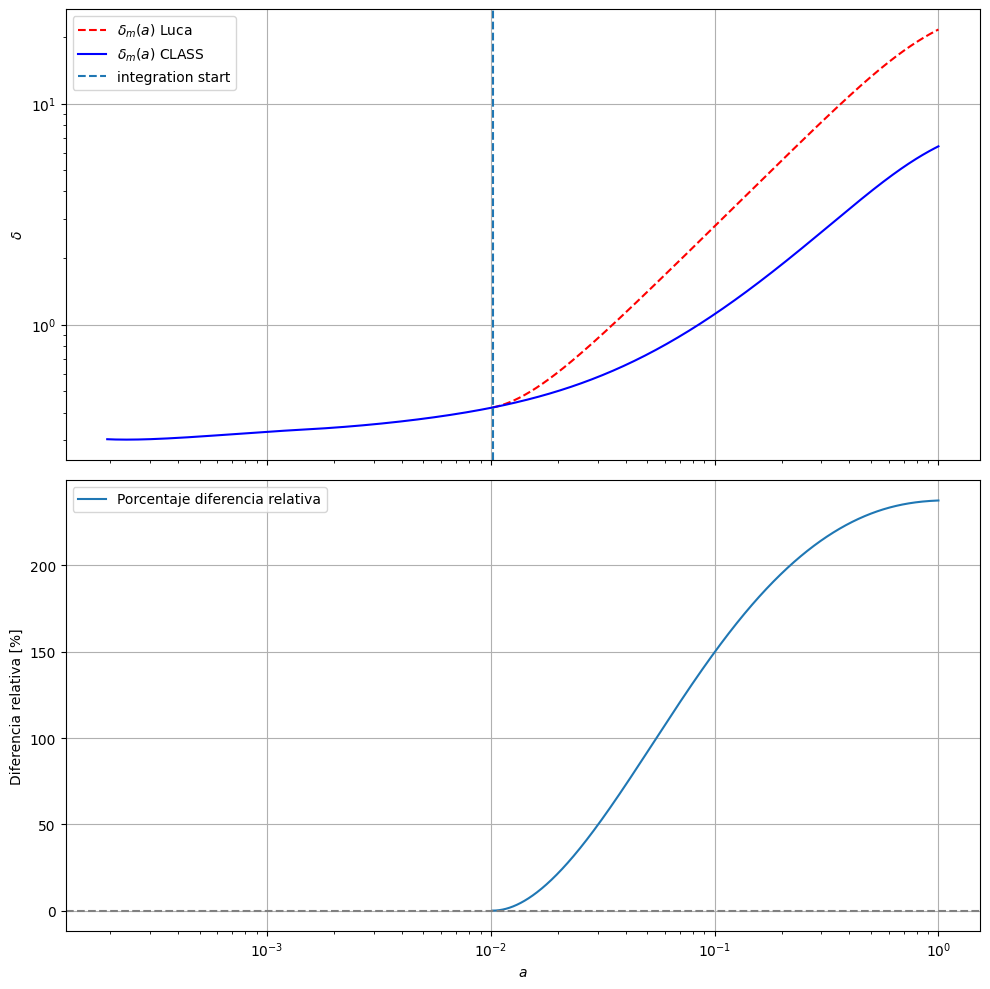

In [9]:
def get_delta_cdm_vs_a(params, delta_0= delta0, delta_prima_0= delta_prima0, a_0=a0, a_f=af ,method='RK45', atol=1e-10, rtol=1e-8):
    """
    Integra la ecuación diferencial para delta_m vs con solve_ivp.
    Permite elegir método y tolerancias.
    Args:
        params: Tuple (Om_m, sigma8)
        method: Método de solve_ivp ('RK45', 'DOP853', 'Radau', etc.)
        atol: Tolerancia absoluta
        rtol: Tolerancia relativa
    Returns:
        a_vec: Array de scale factors
        delta_num: Array de delta_cdm values
    """
    a_vec = np.linspace(a_0, a_f, 20000)
    def F(a, X):
        f1 = X[1]
        term1 = X[0] * 3 * params[0] / (2 * (Hh(params, a) ** 2) * (a ** 5))
        term2 = -X[1] * ((3 / a) + (Hh_p(params, a) / Hh(params, a)))
        f2 = term1 + term2
        return np.array([f1, f2])
    out2 = solve_ivp(
        fun=F,
        t_span=[a_0, a_f],
        y0=np.array([delta_0, delta_prima_0]),
        t_eval=a_vec,
        method=method,
        atol=atol,
        rtol=rtol
    )
    if not out2.success:
        print(f"Warning: solve_ivp did not converge with method {method}: {out2.message}")
    delta_num = out2.y[0]
    return a_vec, delta_num

def percent_diff_vs_class(a_vec, delta_m, a_class, delta_m_class):
    """
    Interpola la curva de CLASS (o cualquiera) 
    sobre los puntos de integración y calcula el porcentaje de diferencia relativa.
    Args:
        a_vec: Array de scale factors de la integración numérica.
        delta_m: Array que quiero comparar.
        a_class: Array de scale factors de (variable independiente del array de comparación).
        delta_m_class: Array de comparación (pensado para que sea el del CLASS).
    """
    interp_class = interp1d(a_class, delta_m_class, kind='quadratic',
                             bounds_error=False, fill_value="extrapolate")
    delta_m_class_interp = interp_class(a_vec)
    percent_diff = 100 * (delta_m - delta_m_class_interp) / delta_m_class_interp
    # percent_diff = -100 * (delta_m - delta_m_class_interp) / delta_m
    return percent_diff

# integración de numérica de luca
a_vec, delta_m = get_delta_cdm_vs_a(params)

# porcentaje de diferencia relativa RESPECTO AL CLASS
percent_diff = percent_diff_vs_class(a_vec, delta_m, df['a'], -delta_m_df)

fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# curvas
axs[0].plot(a_vec, delta_m, 'r--', label=r"$\delta_{m}(a)$ Luca")
axs[0].plot(df['a'], -delta_m_df, label=r"$\delta_{m}(a)$ CLASS", color='blue')
axs[0].axvline(x=a_vec[0], ls='--', label='integration start')
axs[0].set_ylabel(r"$\delta$")
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].legend()
axs[0].grid(True)

# diferencia porcentual
axs[1].plot(a_vec, percent_diff, label='Porcentaje diferencia relativa')
axs[1].axhline(0, color='gray', ls='--')
axs[1].set_xlabel('$a$')
axs[1].set_ylabel('Diferencia relativa [%]')
axs[1].set_xscale('log')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

## Comparaciones
De acá para abajo hay comparaciones con distintos métodos de integración y métodos de derivadas numéricas. 

Las concluciones a las que llegué son:
- Las derivadas numéricas son bastante consistentes. En $a \approx 1$ sí hay diferencias significativas entre cada valor, pero en $a \approx 10^{-3}$ (donde agarramos los valores para condiciones iniciales de la integración de Luca), la diferencia es realmente mínima.
- Los métodos de integración son hiperconsistentes. Achicar la tolerancia o cambiar de runge kutta 5 a runge kutta 8 realmente no hace diferencia en el cómputo.

La diferencia obtenida entre el CLASS y lo de Luca está en otro lado.

### Comparación de métodos de derivación numérica para $\delta_m'(a)$

Esta celda define y compara diferentes métodos para calcular la derivada numérica de $\delta_m$ respecto a $a$.

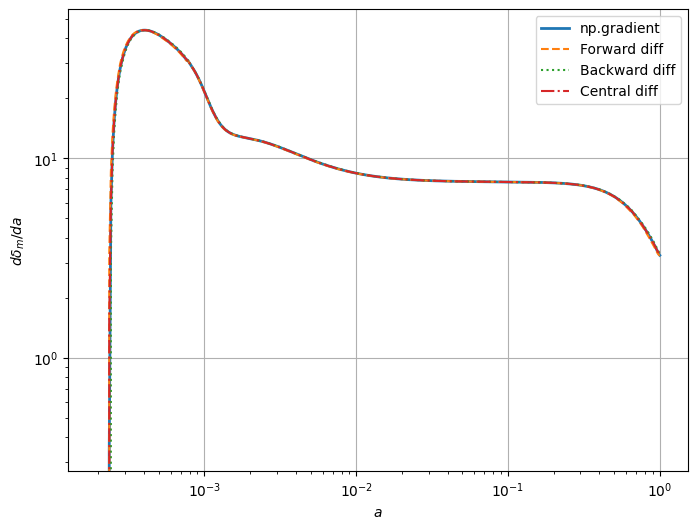

Derivadas en el índice inicial (a >= 1e-3):
np.gradient: 21.52813829367733
Forward diff: 21.36650619294302
Backward diff: 21.689260529970067
Central diff: 21.527628429234017


In [10]:
# Método 1: np.gradient

def gradiente(a, delta):
    """Derivada usando np.gradient (central differences)."""
    return np.gradient(delta, a)

# Método 2: diferencias finitas hacia adelante

def forward_diff(a, delta):
    """Derivada por diferencias finitas hacia adelante."""
    da = np.diff(a)
    ddelta = np.diff(delta)
    deriv = ddelta / da
    # El último valor se repite para igualar el tamaño
    return np.append(deriv, deriv[-1])

# Método 3: diferencias finitas hacia atrás

def backward_diff(a, delta):
    """Derivada por diferencias finitas hacia atrás."""
    da = np.diff(a)
    ddelta = np.diff(delta)
    deriv = ddelta / da
    # El primer valor se repite para igualar el tamaño
    return np.insert(deriv, 0, deriv[0])

# Método 4: diferencias centradas manual

def central_diff(a, delta):
    """Derivada centrada manual."""
    deriv = np.zeros_like(delta)
    deriv[1:-1] = (delta[2:] - delta[:-2]) / (a[2:] - a[:-2])
    deriv[0] = (delta[1] - delta[0]) / (a[1] - a[0])
    deriv[-1] = (delta[-1] - delta[-2]) / (a[-1] - a[-2])
    return deriv

# Aplicar los métodos a la curva de CLASS
a_class = np.array(df['a'])
delta_m_class = -delta_m_df

deriv_grad = gradiente(a_class, delta_m_class)
deriv_forward = forward_diff(a_class, delta_m_class)
deriv_backward = backward_diff(a_class, delta_m_class)
deriv_central = central_diff(a_class, delta_m_class)

plt.figure(figsize=(8,6))
plt.plot(a_class, deriv_grad, label='np.gradient', lw=2)
plt.plot(a_class, deriv_forward, '--', label='Forward diff')
plt.plot(a_class, deriv_backward, ':', label='Backward diff')
plt.plot(a_class, deriv_central, '-.', label='Central diff')
plt.xlabel('$a$')
plt.ylabel(r"$d\delta_m/da$")
plt.xscale('log')
plt.yscale('log')
# plt.title('Comparación de métodos de derivación numérica')
plt.legend()
plt.grid(True)
plt.show()

initial_index = np.where(a_class >= 1e-3)[0][0]  # first index where a >= 1e-3
#print all the derivates in the initial index
print("Derivadas en el índice inicial (a >= 1e-3):")
print(f"np.gradient: {deriv_grad[initial_index]}")
print(f"Forward diff: {deriv_forward[initial_index]}")
print(f"Backward diff: {deriv_backward[initial_index]}")
print(f"Central diff: {deriv_central[initial_index]}")

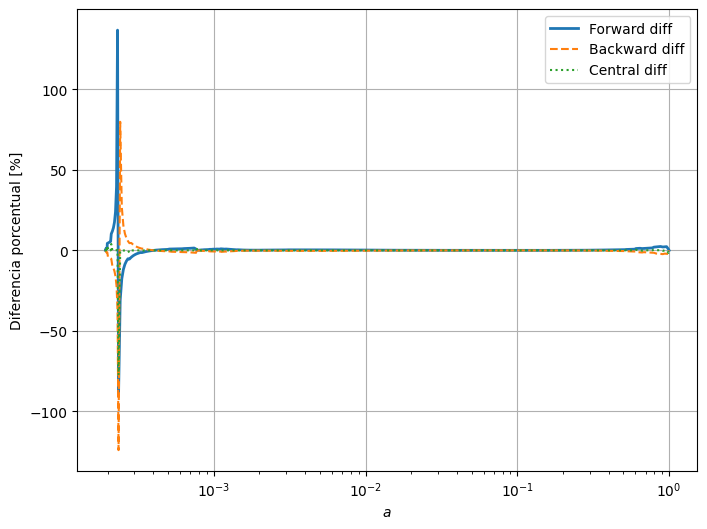

In [11]:
# diferencias porcentuales entre los métodos

dif_forward= percent_diff_vs_class(a_class, deriv_grad, a_class, deriv_forward)
dif_backward = percent_diff_vs_class(a_class, deriv_grad, a_class, deriv_backward)
dif_central = percent_diff_vs_class(a_class, deriv_grad, a_class, deriv_central)
plt.figure(figsize=(8,6))
plt.plot(a_class, dif_forward, label='Forward diff', lw=2)
plt.plot(a_class, dif_backward, '--', label='Backward diff')
plt.plot(a_class, dif_central, ':', label='Central diff')   
plt.xlabel('$a$')
plt.ylabel('Diferencia porcentual [%]')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

Las derivadas numéricas dan maso menos lo mismo. Es verdad que para $a \approx 1$ hay cierta de diferencia, pero para $a \approx e-03$ (cuando le pasamos las CI al código de luca) es practicamente cero. Debería dar lo mismo el método de derivación; el problema debe estar en la integración.

### Comparación de métodos integradores

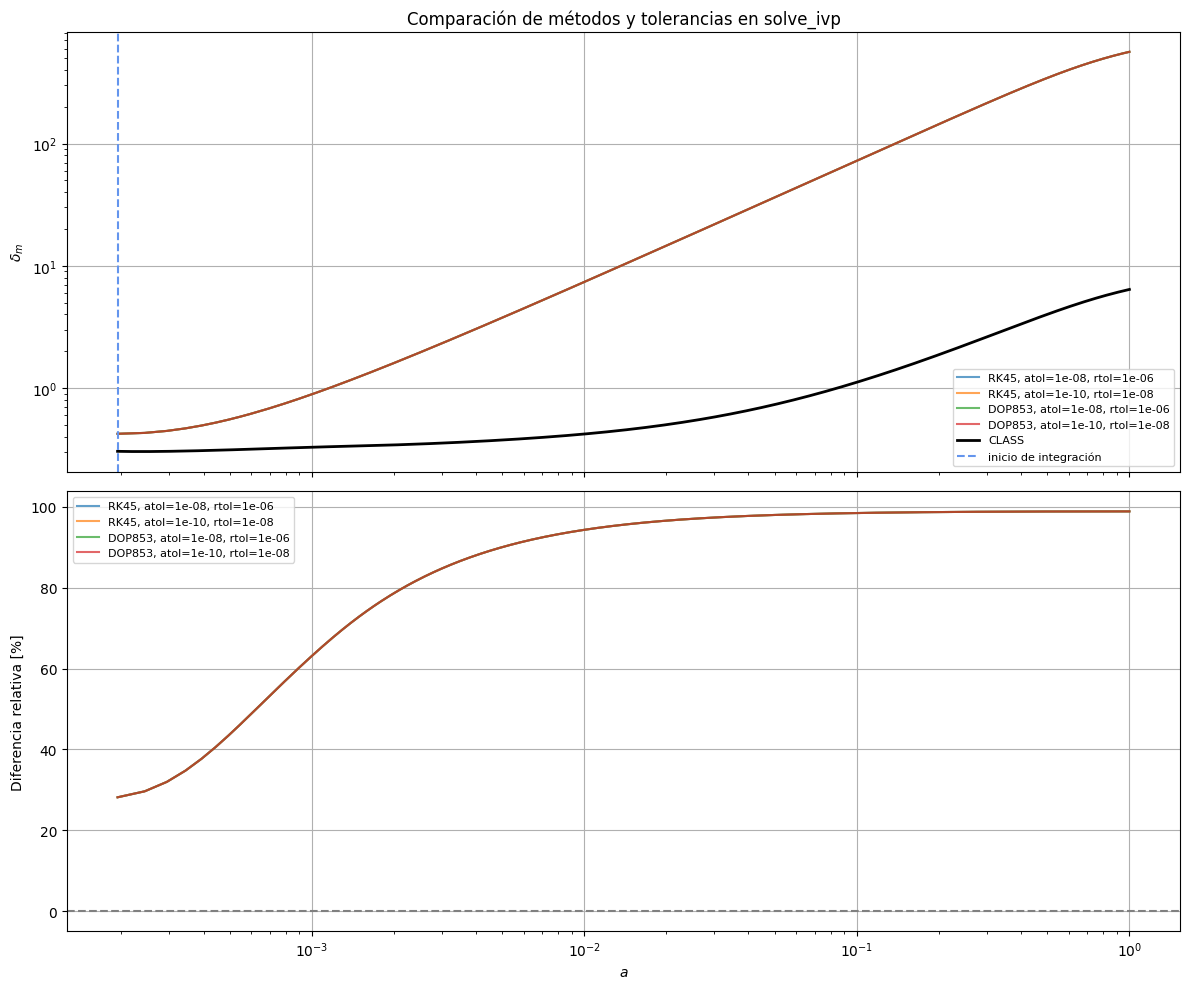

In [12]:
from scipy.interpolate import interp1d

def get_delta_cdm_vs_a(params, method='RK45', atol=1e-10, rtol=1e-8):
    """
    Integra la ecuación diferencial para delta_m vs con solve_ivp.
    Permite elegir método y tolerancias.
    Args:
        params: Tuple (Om_m, sigma8)
        method: Método de solve_ivp ('RK45', 'DOP853', 'Radau', etc.)
        atol: Tolerancia absoluta
        rtol: Tolerancia relativa
    Returns:
        a_vec: Array de scale factors
        delta_num: Array de delta_cdm values
    """
    a_vec = np.linspace(a_0, a_f, 20000)
    def F(a, X):
        f1 = X[1]
        term1 = X[0] * 3 * params[0] / (2 * (Hh(params, a) ** 2) * (a ** 5))
        term2 = -X[1] * ((3 / a) + (Hh_p(params, a) / Hh(params, a)))
        f2 = term1 + term2
        return np.array([f1, f2])
    out2 = solve_ivp(
        fun=F,
        t_span=[a_0, a_f],
        y0=np.array([delta0, delta_prima0]),
        t_eval=a_vec,
        method=method,
        atol=atol,
        rtol=rtol
    )
    if not out2.success:
        print(f"Warning: solve_ivp did not converge with method {method}: {out2.message}")
    delta_num = out2.y[0]
    return a_vec, delta_num

def percent_diff_vs_class(a_vec, delta_m, a_class, delta_m_class):
    """
    Interpola la curva de CLASS sobre los puntos de integración y calcula el porcentaje de diferencia relativa.
    """
    interp_class = interp1d(a_class, delta_m_class, kind='quadratic', bounds_error=False, fill_value="extrapolate")
    delta_m_class_interp = interp_class(a_vec)
    percent_diff = 100 * (delta_m - delta_m_class_interp) / delta_m
    return percent_diff

# Métodos y tolerancias a comparar
methods = ['RK45', 'DOP853']
tolerances = [
    (1e-8, 1e-6), 
    (1e-10, 1e-8)
    # (1e-12, 1e-10)
               ]

a_class = np.array(df['a'])
delta_m_class = -delta_m_df

fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

for method in methods:
    for atol, rtol in tolerances:
        a_vec, delta_m = get_delta_cdm_vs_a(params, method=method, atol=atol, rtol=rtol)
        label = f"{method}, atol={atol}, rtol={rtol}"
        axs[0].plot(a_vec, delta_m, label=label, alpha=0.7)
        percent_diff = percent_diff_vs_class(a_vec, delta_m, a_class, delta_m_class)
        axs[1].plot(a_vec, percent_diff, label=label, alpha=0.7)

# Plot CLASS en el primer subplot
axs[0].plot(a_class, delta_m_class, 'k', lw=2, label='CLASS')
#vertical line in the start of delta_m
axs[0].axvline(x= a_vec[0], ls='--', label='inicio de integración', color='cornflowerblue')
axs[0].set_ylabel(r"$\delta_m$")
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].legend(fontsize=8)
axs[0].set_title("Comparación de métodos y tolerancias en solve_ivp")
axs[0].grid(True)

# Segundo subplot: diferencias porcentuales
axs[1].axhline(0, color='gray', ls='--')
axs[1].set_xlabel('$a$')
axs[1].set_ylabel('Diferencia relativa [%]')
axs[1].set_xscale('log')
axs[1].legend(fontsize=8)
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [13]:
omr= M.Omega_r()
om=0.315
aeq=omr/om
print(f"aeq: {aeq}")
print(10e-5)
print(M.Omega_r())

aeq: 0.0002871550879186109
0.0001
9.045385269436243e-05


### Comparación con one_k desde output:

In [14]:
def set_column_names(df, path):
    # Set column names based on the first line of the file
    with open(path) as f:
        for line in f:
            if line.startswith('#') and ':' in line:
                columns = [col.split(':')[1].strip() for col in line[1:].split('  ') if ':' in col]
                df.columns = columns
                break
    return df

def read_ini_params(filepath):
    '''
    Obtiene los parameters k, omega_b y omega cdm from an .ini file and returns them as a dictionary.
    Args:
        filepath (str): Path to the .ini file.
    Returns:
        dict: Dictionary containing the parameters.
    '''
    params = {
        "k_output_values": None,
        "Omega_b": None,
        "Omega_cdm": None
    }
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line.startswith("#") or line.startswith(";") or line == "": #evito los comentarios y líneas vacías
                continue
            if "=" in line:
                key, value = [x.strip() for x in line.split("=", 1)] #separo valores
                if key in params:
                    params[key] = float(value) #agrego al dicc
    return params



In [15]:
path = '/home/pedrorozin/scripts/class_public/output/test_delta_prime_23_perturbations_k0_s.dat'

path2 = '/home/pedrorozin/scripts/class_public/output/test_delta_prime_24_perturbations_k0_s.dat'

df3 = pd.read_csv(
    path,
    comment='#',
    sep='\s+',
    header=None,
    skiprows=1  
)

df2= pd.read_csv(
    path2,
    comment='#',
    sep='\s+',
    header=None,
    skiprows=1  
)

df3 = set_column_names(df3, path)
df2 = set_column_names(df2, path2)
df3 = df3.rename(columns={'tau [Mpc]': 'tau'})
df2 = df2.rename(columns={'tau [Mpc]': 'tau'})
columnas_relevantes = ['tau', 'a', 'delta_cdm', 'delta_b', 'delta_prime_cdm', 'delta_prime_b']
df3 = df3[columnas_relevantes]
df2 = df2[columnas_relevantes]
display(df2.head())

,tau,a,delta_cdm,delta_b,delta_prime_cdm,delta_prime_b
0,81.234917,0.000209,-1.059149,-1.059149,0.001704,0.001704
1,81.234929,0.000209,-1.059149,-1.059149,0.001704,0.001704
2,81.234940,0.000209,-1.059149,-1.059149,0.001704,0.001704
3,81.235055,0.000209,-1.059149,-1.059149,0.001704,0.001704
4,81.235171,0.000209,-1.059149,-1.059149,0.001704,0.001704


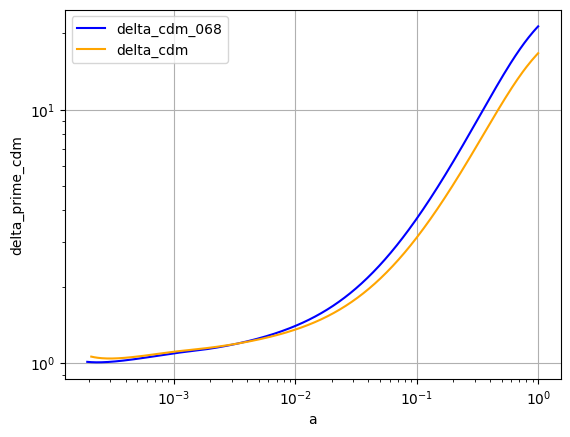

In [16]:
plt.plot(df3['a'], -df3['delta_cdm'], label='delta_cdm_068', color='blue')
plt.plot(df2['a'], -df2['delta_cdm'], label='delta_cdm', color='orange')
plt.xlabel('a')
plt.ylabel('delta_prime_cdm')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()


In [17]:
#parametros para integrar:

ini_file_path = "/home/pedrorozin/scripts/class_public/test_delta_prime_gauge_newtonian.ini"
params = read_ini_params(ini_file_path)

om_b = params['Omega_b']
om_cdm = params['Omega_cdm']
om_m = om_b + om_cdm
k = params['k_output_values']
# Imprimir los parámetros	
print(f"omega_b: {om_b}, omega_cdm: {om_cdm}, omega_m: {om_m}, k: {k}")

#agrego delta_m y delta_m_prime a df3
df3['delta_m'] = om_cdm/om_m * df3['delta_cdm'] + om_b/om_m * df3['delta_b']
df3['delta_m_prime'] = om_cdm/om_m * df3['delta_prime_cdm'] + om_b/om_m * df3['delta_prime_b']

df2['delta_m'] = om_cdm/om_m * df2['delta_cdm'] + om_b/om_m * df2['delta_b']
df2['delta_m_prime'] = om_cdm/om_m * df2['delta_prime_cdm'] + om_b/om_m * df2['delta_prime_b']

# condiciones iniciales
a= np.array(df3['a'])
delta_cdm = np.array(df3['delta_cdm'])
delta_b = np.array(df3['delta_b'])

initial_index = np.where(a >= 1e-2)[0][0]  # first index where a >= 1e-3
a_0 = a[initial_index]
a_f = a[-1]

delta_0= -df3['delta_m'][initial_index]
delta_prima_0= -df3['delta_m_prime'][initial_index]
print('delta_0:', delta_0)
print('delta_prima_0:', delta_prima_0)


omega_b: 0.05, omega_cdm: 0.25, omega_m: 0.3, k: 0.001
delta_0: 1.4055672813343334
delta_prima_0: 0.00035680055325840003


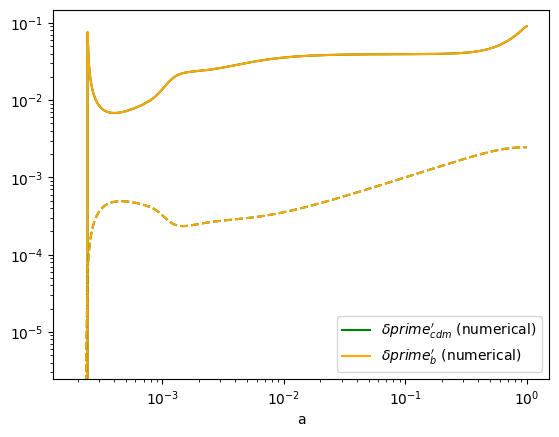

In [18]:
delta_numeric = np.gradient(a, df3['delta_m'])
delta_cdm_numeric = np.gradient(a, df3['delta_cdm'])
delta_b_numeric = np.gradient(a, df3['delta_b'])


# plt.plot(a, -delta_numeric, color = 'blue')
# plt.plot(a, -df3['delta_m_prime'], color = 'red')
plt.plot(a, -delta_cdm_numeric, color = 'green', label = r"$\delta prime_{cdm}'$ (numerical)")
plt.plot(a, -delta_b_numeric, color = 'orange', label = r"$\delta prime_{b}'$ (numerical)")
plt.plot(a, -df3['delta_prime_cdm'], color = 'green', linestyle='--')
plt.plot(a, -df3['delta_prime_b'], color = 'orange', linestyle='--')
plt.xlabel('a')
#legend
plt.legend()
plt.xscale('log')
plt.yscale('log')

In [19]:
def get_delta_cdm_vs_a(params, delta_0= delta0, delta_prima_0= delta_prima0,
                        a_0=a0, a_f=af ,method='RK45', atol=1e-10, rtol=1e-8):
    """
    Integra la ecuación diferencial para delta_m vs con solve_ivp.
    Permite elegir método y tolerancias.
    Args:
        params: Tuple (Om_m, sigma8)
        method: Método de solve_ivp ('RK45', 'DOP853', 'Radau', etc.)
        atol: Tolerancia absoluta
        rtol: Tolerancia relativa
    Returns:
        a_vec: Array de scale factors
        delta_num: Array de delta_cdm values
    """
    a_vec = np.linspace(a_0, a_f, 20000)
    def F(a, X):
        f1 = X[1]
        term1 = X[0] * 3 * params[0] / (2 * (Hh(params, a) ** 2) * (a ** 5))
        term2 = -X[1] * ((3 / a) + (Hh_p(params, a) / Hh(params, a)))
        f2 = term1 + term2
        return np.array([f1, f2])
    out2 = solve_ivp(
        fun=F,
        t_span=[a_0, a_f],
        y0=np.array([delta_0, delta_prima_0]),
        t_eval=a_vec,
        method=method,
        atol=atol,
        rtol=rtol
    )
    if not out2.success:
        print(f"Warning: solve_ivp did not converge with method {method}: {out2.message}")
    delta_num = out2.y[0]
    return a_vec, delta_num

delta_0: 1.4055672813343334
delta_prima_0: 0.00035680055325840003


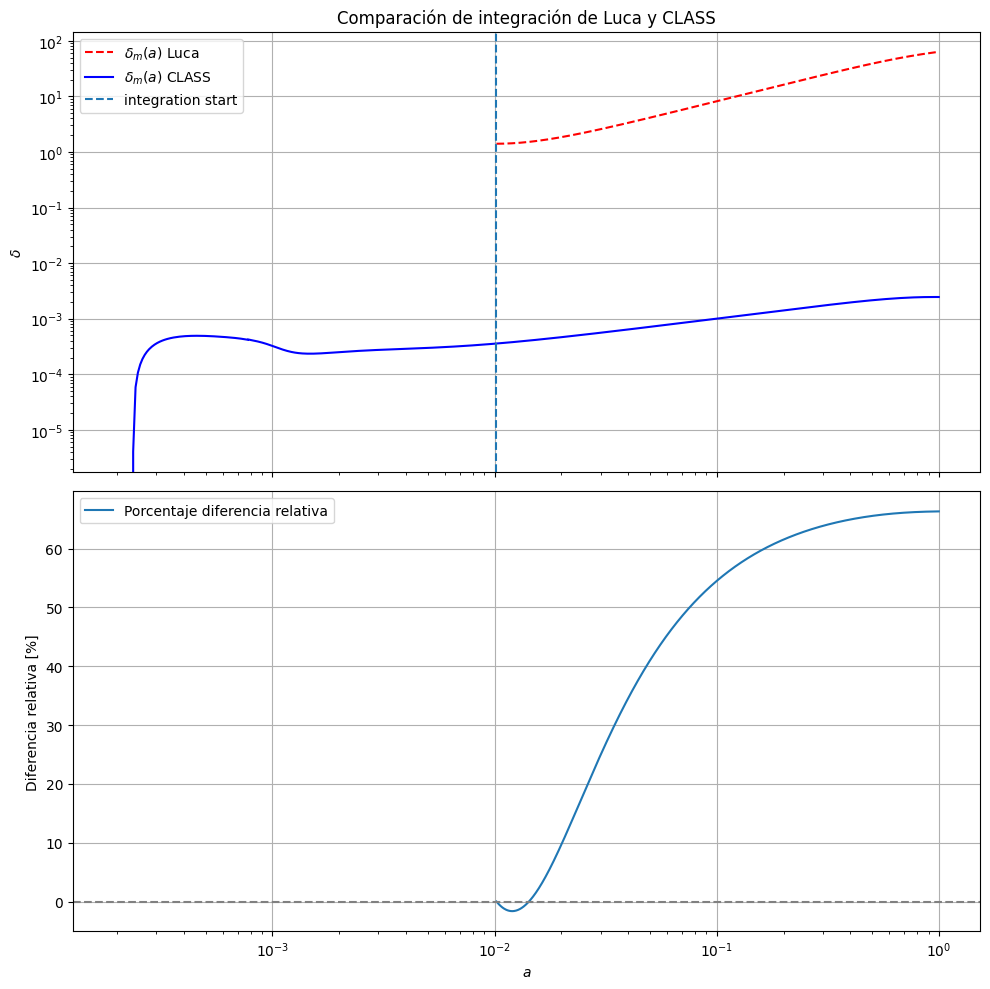

In [20]:
initial_index = np.where(a >= 1e-2)[0][0]  # first index where a >= 1e-3
a_0 = a[initial_index]
a_f = a[-1]
delta0= -df3['delta_m'][initial_index]
delta_prima0= -df3['delta_m_prime'][initial_index]
print('delta_0:', delta0)
print('delta_prima_0:', delta_prima0)


a_vec, delta_m = get_delta_cdm_vs_a((om_m, 0.8), delta_0= delta0, delta_prima_0=delta_prima0,a_0= a_0, a_f= a_f,
                                     method='RK45', atol=1e-10, rtol=1e-8)
percent_diff = percent_diff_vs_class(a_vec, delta_m, df3['a'], -df3['delta_m'])

delta_numeric = np.gradient(delta_m, a_vec)


fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
# curvas
axs[0].plot(a_vec, delta_m, 'r--', label=r"$\delta_{m}(a)$ Luca")
axs[0].plot(df3['a'], -df3['delta_m_prime'], label=r"$\delta_{m}(a)$ CLASS", color='blue')
axs[0].axvline(x=a_vec[0], ls='--', label='integration start')
axs[0].set_ylabel(r"$\delta$")
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].legend()
axs[0].set_title("Comparación de integración de Luca y CLASS")
axs[0].grid(True)
# Segundo subplot: diferencias porcentuales
axs[1].plot(a_vec, percent_diff, label='Porcentaje diferencia relativa')
axs[1].axhline(0, color='gray', ls='--')
axs[1].set_xlabel('$a$')
axs[1].set_ylabel('Diferencia relativa [%]')
axs[1].set_xscale('log')
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.show()



## Comparacion con condiciones iniciales obtenidas del file escrito ad hoc

In [21]:
from scipy.integrate import simpson
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
from classy import Class

### check parámetros cosmológicos:

In [22]:
def read_ini_params(filepath):
    '''
    Obtiene los parameters k, omega_b y omega cdm from an .ini file and returns them as a dictionary.
    Args:
        filepath (str): Path to the .ini file.
    Returns:
        dict: Dictionary containing the parameters.
    '''
    params = {
        "k_output_values": None,
        "Omega_b": None,
        "Omega_cdm": None,
        'h': None,
        'A_s': None,
        'n_s': None,
        'tau_reio': None,
        'YHe': None
    }
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line.startswith("#") or line.startswith(";") or line == "": #evito los comentarios y líneas vacías
                continue
            if "=" in line:
                key, value = [x.strip() for x in line.split("=", 1)] #separo valores
                if key in params:
                    params[key] = float(value) #agrego al dicc
    return params

def set_column_names(df, path):
    # Set column names based on the first line of the file
    with open(path) as f:
        for line in f:
            if line.startswith('#') and ':' in line:
                columns = [col.split(':')[1].strip() for col in line[1:].split('  ') if ':' in col]
                df.columns = columns
                break
    return df

def common_settings(k=0.01, omega_cdm=.25, A_s=2e-9, h=0.68, ns=0.9660499, tau_reio=0.05430842, YHe=0.2454): 
  """
  Set common settings for the CLASS simulation.
  Esto hace basicamente lo mismo que el diccionario de common_settings del principio (el de Julien),
    pero con los valores de k, omega_cdm, A_s y h como argumentos.

  Args:
    k (float): Value of k for the simulation.
    omega_cdm (float): Omega_cdm value for the simulation.
    A_s (float): A_s value for the simulation.
    h (float): h value for the simulation.

  Returns:
    A dictionary containing the common settings for the simulation.
  """
  _common_settings = {
    'output': 'mPk',
    'k_output_values': k,
    'h': h,
    'Omega_b': 0.3-omega_cdm,
    'Omega_cdm': omega_cdm,
    'A_s': A_s,
    'n_s': ns,
    'tau_reio': tau_reio,
    'YHe': YHe,
    'compute damping scale': 'yes',
    'gauge': 'newtonian'
    }
  M = Class()
  M.set(_common_settings)
  M.compute()
  return M

def k_horizont(a0 =.01, Om_m = 0.315, Om_lambda = 0.685, Om_r = 0.0001):
    """
    Calculate the comoving wavenumber of the horizon at a given scale factor.
    Args:
        a0 (float): The scale factor at which to calculate the comoving wavenumber of the horizon.
        Om_m (float): The matter density parameter at a=1.
        Om_lambda (float): The dark energy density parameter at a=1, calculated as
                           Om_lambda = 1 - Om_m - Om_r.
        Om_r (float): The radiation density parameter at a=1, calculated as
                      Om_r = 0.0001 (or any other value).
    Returns:
        float: The comoving wavenumber of the horizon at the given scale factor.
    """
    return a0/(2*np.pi) * np.sqrt(Om_m * a0**(-3) + Om_lambda  + Om_r * a0**(-4))



In [23]:
#read ini file parameters
ini_file_path = "/home/pedrorozin/scripts/class_public/test_delta_prime_gauge_newtonian.ini"
params = read_ini_params(ini_file_path)
# print(f"Parameters from ini file: {params}")
om_b = params['Omega_b']
om_cdm = params['Omega_cdm']
om_m = om_b + om_cdm
k = params['k_output_values']
A_s = params['A_s']
h = params['h']
n_s = params['n_s']
tau_reio = params['tau_reio']
YHe = params['YHe']
#generate M from CLASS to get Omega_radiation and Omega_lambda
M = common_settings(k=k, omega_cdm=om_cdm, A_s=A_s, h=h, ns=n_s, tau_reio=tau_reio, YHe=YHe)
# Imprimir los parámetros
print(f"omega_b: {om_b}, omega_cdm: {om_cdm}, omega_m: {om_m}, k: {k}, A_s: {A_s}, h: {h}, n_s: {n_s}, tau_reio: {tau_reio}, YHe: {YHe}")
#obtener Omega_radiation y Omega_lambda
Om_r = M.Omega_r()
om_l = M.Omega_Lambda()
print(f"Omega_radiation: {Om_r}, Omega_lambda: {om_l}")
print('------')
k_horizont_value = k_horizont(a0=1e-02, Om_m=om_m, Om_lambda=om_l, Om_r=Om_r)
print(f'con estos parámetros, el k_horizonte es: {k_horizont_value} h/Mpc')


omega_b: 0.05, omega_cdm: 0.25, omega_m: 0.3, k: 0.001, A_s: 2e-09, h: 0.68, n_s: 0.965, tau_reio: 0.05430842, YHe: 0.2454
Omega_radiation: 9.045385269436243e-05, Omega_lambda: 0.6999095461473057
------
con estos parámetros, el k_horizonte es: 0.8847727836903274 h/Mpc


### funciones:

In [24]:
def get_sigma8(M):
  """
  Extracts the current value of sigma8 from the perturbations dictionary.

  Args:
    dicc: The perturbations dictionary (default: all_k['scalar'][0]).

  Returns:
    The current value of sigma8.
  """

  _sigma= M.get_current_derived_parameters(['sigma8'])
  return _sigma['sigma8']


def delta_prima(df_results):
    """
    Calcula la derivada numérica de 'delta_cdm' con respecto a 'a' en cada fila del DataFrame.

    Args:
        df_results (pd.DataFrame): DataFrame con columnas 'a' y 'delta_cdm', donde cada celda contiene un vector.

    Returns:
        pd.Series: Una serie con los vectores de la derivada para cada fila.
    """
    def calculate_gradient(row):
        if len(row["delta_cdm"]) == len(row["a"]):
            return np.gradient(row["delta_cdm"], row["a"])
        else:
            # send warning if not
            print(f"Warning: Length mismatch in row {row.name}. Returning NaNs.")
            #print len of each rows
            print(f"Length of 'a': {len(row['a'])}")
            print(f"Length of 'delta_cdm': {len(row['delta_cdm'])}")
            return [np.nan] * len(row["a"]) #return nan en el caso patologico de mismatch lenghts

    return df_results.apply(calculate_gradient, axis=1)


def get_df_from_M(M): #tal vez lo modifique para obtener las derivadas directamente acá. sería útil para la grilla.
  """
  Extracts 'delta_cdm', 'a', and 'tau [Mpc]' vectors from the perturbations.
  It does not extract inputs of the perturbation dictionary (like A_s, h, omega...)

  Args:
    class: M - (example: common_settings(k=1)).

  Returns:
    A Pandas DataFrame containing the desired vectors.
  """
  all_k = M.get_perturbations()
  one_k = all_k['scalar'][0]
  a = one_k['a']
  tau = one_k['tau [Mpc]']
  delta_cdm = one_k['delta_cdm']
  delta_b = one_k['delta_b']
  df = pd.DataFrame({'tau [Mpc]': tau, 'a': a, 'delta_cdm': delta_cdm, 'delta_b': delta_b})
  return df


def Hh(params,a, Om_r = Om_r):
    """
    Calcula el Hubble parameter dado 'a'. Está normalizado a 1 en a=1 (H_0=1). 
    Args:
        params (tuple): A tuple containing the matter density parameter (Om_m_0) and sigma8.
        sigma8 es mudo para las ecuaciones, no se usa.
        Om_r (float): The radiation density parameter. No está definido acá (corregirlo en un futuro con tiempo),
          pero sale del CLASS output con M.Omega_r().
        Om_m_0 (float): The matter density parameter at a=1.
        Om_L (float): The dark energy density parameter at a=1, calculated as
                      Om_L = 1 - Om_m_0 - Om_r.
        a (float or array-like): The scale factor at which to calculate the Hubble parameter.
    Returns:
        float or array-like: The Hubble parameter at the given scale factor 'a'.
    """
    Om_m_0, s8=params
    Om_L=1-Om_m_0-Om_r
    return np.sqrt(Om_L+Om_m_0/a**3+Om_r/a**4)

def Hh_p(params,a, Om_r = Om_r):
    """Calcula la derivada del Hubble parameter con respecto a 'a'.
    Args:
        params (tuple): A tuple containing the matter density parameter (Om_m_0) and sigma8.
        sigma8 es mudo para las ecuaciones, no se usa.
        Om_r (float): The radiation density parameter sale del CLASS output con M.Omega_r()
        Om_m_0 (float): The matter density parameter at a=1.
        Om_L (float): The dark energy density parameter at a=1, calculated as
                      Om_L = 1 - Om_m_0 - Om_r.
        a (float or array-like): The scale factor at which to calculate the derivative of the Hubble parameter.
    Returns:
        float or array-like: The derivative of the Hubble parameter with respect to 'a'.
    """
    Om_m_0, s8=params
    Om_L = 1-Om_m_0-Om_r
    num = (3*Om_m_0/a**4+4*Om_r/a**5)
    den = 2*np.sqrt(Om_L+Om_m_0/a**3+Om_r/a**4)
    return -num/den

def get_delta_cdm_vs_a(params, delta_0= delta0,
                        delta_prima_0= delta_prima0, a_0=a0, a_f=af ,method='RK45',
                          atol=1e-10, rtol=1e-8, omr= Om_r):
    """
    Integra la ecuación diferencial para delta_m vs con solve_ivp.
    Permite elegir método y tolerancias.
    Args:
        params: Tuple (Om_m, sigma8)
        method: Método de solve_ivp ('RK45', 'DOP853', 'Radau', etc.)
        atol: Tolerancia absoluta
        rtol: Tolerancia relativa
    Returns:
        a_vec: Array de scale factors
        delta_num: Array de delta_cdm values
    """
    a_vec = np.linspace(a_0, a_f, 20000)
    def F(a, X):
        f1 = X[1]
        term1 = X[0] * 3 * params[0] / (2 * (Hh(params, a, Om_r=omr) ** 2) * (a ** 5))
        term2 = -X[1] * ((3 / a) + (Hh_p(params, a, Om_r=omr) / Hh(params, a, Om_r=omr)))
        f2 = term1 + term2
        return np.array([f1, f2])
    out2 = solve_ivp(
        fun=F,
        t_span=[a_0, a_f],
        y0=np.array([delta_0, delta_prima_0]),
        t_eval=a_vec,
        method=method,
        atol=atol,
        rtol=rtol
    )
    if not out2.success:
        print(f"Warning: solve_ivp did not converge with method {method}: {out2.message}")
    delta_num = out2.y[0]
    return a_vec, delta_num

def percent_diff_vs_class(a_vec, delta_m, a_class, delta_m_class):
    """
    Interpola la curva de CLASS (o cualquiera) sobre los puntos de integración y calcula el porcentaje de diferencia relativa.
    Si hay valores duplicados en a_class, solo toma el primero.
    """
    a_class = np.asarray(a_class)
    delta_m_class = np.asarray(delta_m_class)
    # Solo eliminar duplicados si existen
    if len(np.unique(a_class)) < len(a_class):
        _, unique_indices = np.unique(a_class, return_index=True)
        a_class = a_class[unique_indices]
        delta_m_class = delta_m_class[unique_indices]
    interp_class = interp1d(a_class, delta_m_class, kind='quadratic',
                            bounds_error=False, fill_value="extrapolate")
    delta_m_class_interp = interp_class(a_vec)
    # percent_diff = 100 * (delta_m - delta_m_class_interp) / delta_m_class_interp
    percent_diff = -100 * (delta_m - delta_m_class_interp) / delta_m
    return percent_diff

def read_ini_params(filepath):
    '''
    Obtiene los parameters k, omega_b y omega cdm from an .ini file and returns them as a dictionary.
    Args:
        filepath (str): Path to the .ini file.
    Returns:
        dict: Dictionary containing the parameters.
    '''
    params = {
        "k_output_values": None,
        "Omega_b": None,
        "Omega_cdm": None,
        'h': None,
        'A_s': None,
        'n_s': None,
        'tau_reio': None,
        'YHe': None
    }
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line.startswith("#") or line.startswith(";") or line == "": #evito los comentarios y líneas vacías
                continue
            if "=" in line:
                key, value = [x.strip() for x in line.split("=", 1)] #separo valores
                if key in params:
                    params[key] = float(value) #agrego al dicc
    return params

def set_column_names(df, path):
    # Set column names based on the first line of the file
    with open(path) as f:
        for line in f:
            if line.startswith('#') and ':' in line:
                columns = [col.split(':')[1].strip() for col in line[1:].split('  ') if ':' in col]
                df.columns = columns
                break
    return df

def deriv_tau_to_a(df, column_name='delta_prime_cdm'):
    """
    apply chain rule to convert tau to a.
    d delta/da = d delta/dtau * d tau/da = dot(delta)/(H a)
    """
    
    df[column_name + '_a'] = df[column_name] / (df['H'] * df['a'])
    return df






### df desde el file que generamos con perturbations.c

In [25]:
path = '/home/pedrorozin/scripts/class_public/delta_prime_cdm.txt' #file escrito con perturbations.c

#import the data as df with first column as 'a' and second column as 'delta_prime_cdm'

df = pd.read_csv(path, sep=' ', names=['delta_cdm', 'delta_prime_cdm', 'a', 'k', 'H'])
df.head()



,,delta_cdm,delta_prime_cdm,a,k,H
-0.902691,-0.016829,-0.902691,-0.016826,4.696919e-07,0.321755,4.596494
-0.902604,-0.025761,-0.902604,-0.025756,2.996558e-07,0.504188,7.202691
-0.902804,-0.011783,-0.902804,-0.011781,6.912142e-07,0.218718,3.124542
-0.902591,-0.027996,-0.902591,-0.027990,2.747651e-07,0.549840,7.854850
-0.902654,-0.019656,-0.902654,-0.019652,3.981810e-07,0.379495,5.421354


In [26]:
#print row with the first value of k greater or equal to 0.01
k_threshold = 0.8
df_filtered = df[df['k'] >= k_threshold]
df_filtered = df_filtered.sort_values(by='k')
df_filtered = df_filtered.reset_index(drop=True)
df_filtered.head()
k= df_filtered['k'].min()

df_k = df_filtered[df_filtered['k'] == df_filtered['k'].min()]
df_k.loc[:, 'delta_prime_cdm'] = -df_k['delta_prime_cdm'].astype(float) #paso todo a positivo (default es negativo)
df_k.loc[:, 'delta_cdm'] = -df_k['delta_cdm'].astype(float) #paso todo a positivo (default es negativo)

#sort by a
df_k = df_k.sort_values(by='a').reset_index(drop=True)

print(max(df_k['a'])) 
#len df
print(len(df_k['a']))
display(df_k.head())
#add derivative respect to a
print('agrego derivada respecto a a')
df_k= deriv_tau_to_a(df_k)
#display df_k
display(df_k.head())



1.0
6768


,delta_cdm,delta_prime_cdm,a,k,H
0,0.902538,0.044308,1.710197e-07,0.883236,12.61766
1,0.902538,0.044308,1.710197e-07,0.883236,12.61766
2,0.902538,0.044308,1.710197e-07,0.883236,12.61766
3,0.902538,0.044308,1.710197e-07,0.883236,12.61766
4,0.902538,0.044308,1.710197e-07,0.883236,12.61766


agrego derivada respecto a a


,delta_cdm,delta_prime_cdm,a,k,H,delta_prime_cdm_a
0,0.902538,0.044308,1.710197e-07,0.883236,12.61766,20533.045216
1,0.902538,0.044308,1.710197e-07,0.883236,12.61766,20533.073021
2,0.902538,0.044308,1.710197e-07,0.883236,12.61766,20533.073021
3,0.902538,0.044308,1.710197e-07,0.883236,12.61766,20533.073021
4,0.902538,0.044308,1.710197e-07,0.883236,12.61766,20533.073021


In [27]:
#print uniques k
unique_ks = df['k'].unique()
# print("Unique k values:", unique_ks)
#print len of the df reamining for each unique k
lenghs = {float(k): len(df[df['k'] == k]) for k in unique_ks}
print("Lengths for each unique k value:", lenghs)
#cantidad de k's:
print(f"Cantidad de k's: {len(unique_ks)}")
#print len of a and len of uniques a
print(f"Cantidad de a's para k={k}: {len(df_k['a'])}")
print(f"Cantidad de a's únicos para k ={k}: {len(df_k['a'].unique())}")

Lengths for each unique k value: {0.3217546: 2895, 0.5041884: 3977, 0.2187179: 2377, 0.5498395: 4488, 0.3794948: 3261, 0.2778346: 2774, 0.2985487: 2720, 0.2419457: 2573, 0.3975973: 3297, 0.469521: 3511, 0.4180134: 3418, 0.7185012: 5127, 0.4415523: 3590, 0.3345316: 2946, 1.109893: 7759, 0.8832362: 6768, 0.6152706: 4344, 0.3482746: 3060, 0.3097978: 2837, 0.2590859: 2604, 0.3631755: 3160, 0.2682399: 2671, 0.1678644: 2137, 0.1059089: 2010, 0.1168959: 1993, 0.12902: 2004, 0.1424014: 2054, 0.1248451: 1998, 0.1471635: 2104, 0.1520851: 2144, 0.1333346: 2023, 0.1734837: 2241, 0.1571718: 2140, 0.1624294: 2139, 0.1792948: 2236, 0.1853059: 2316, 0.2046351: 2386, 0.191526: 2347, 0.05540139: 1936, 0.1979654: 2294, 0.08130504: 2024, 0.2261614: 2525, 0.2879181: 2736, 0.04916471: 1887, 0.0786354: 1969, 0.07352111: 2048, 0.061844: 1919, 0.003506036: 1459, 0.06867831: 1980, 0.2115479: 2423, 0.07106796: 2061, 0.0640712: 1973, 0.07604216: 2012, 0.09594429: 1949, 0.008806765: 1466, 0.08689016: 1947, 0.08405

### plots
acá hay para varios k's y comparación con lo obtenido a través del 'output' del CLASS (es el mismo vector el que sale)

In [28]:
output_path = '/home/pedrorozin/scripts/class_public/output/test_delta_prime_28_perturbations_k0_s.dat'
df_output = pd.read_csv(output_path, comment='#', sep='\s+', header=None, skiprows=1)
df_output = set_column_names(df_output, output_path)
#change tau name
df_output = df_output.rename(columns={'tau [Mpc]': 'tau'})
columnas_relevantes = ['tau', 'a', 'delta_cdm', 'delta_b', 'delta_prime_cdm', 'delta_prime_b']
df_output = df_output[columnas_relevantes]
#convert delta_cdm and delta_prime_cdm to positive
df_output['delta_cdm'] = -df_output['delta_cdm'].astype(float)  # paso todo a positivo (default es negativo)
df_output['delta_prime_cdm'] = -df_output['delta_prime_cdm'].astype(float)  # paso todo a positivo (default es negativo)
display(df_output.head())
print('---------')
print('df from file:')
display(df_k.head())
print('---------')

,tau,a,delta_cdm,delta_b,delta_prime_cdm,delta_prime_b
0,81.234917,0.000209,1.059149,-1.059149,-0.001704,0.001704
1,81.234929,0.000209,1.059149,-1.059149,-0.001704,0.001704
2,81.234940,0.000209,1.059149,-1.059149,-0.001704,0.001704
3,81.235055,0.000209,1.059149,-1.059149,-0.001704,0.001704
4,81.235171,0.000209,1.059149,-1.059149,-0.001704,0.001704


---------
df from file:


,delta_cdm,delta_prime_cdm,a,k,H,delta_prime_cdm_a
0,0.902538,0.044308,1.710197e-07,0.883236,12.61766,20533.045216
1,0.902538,0.044308,1.710197e-07,0.883236,12.61766,20533.073021
2,0.902538,0.044308,1.710197e-07,0.883236,12.61766,20533.073021
3,0.902538,0.044308,1.710197e-07,0.883236,12.61766,20533.073021
4,0.902538,0.044308,1.710197e-07,0.883236,12.61766,20533.073021


---------


acá se ve claro que es el mismo vector el que sale del output que el que escribimos a mano

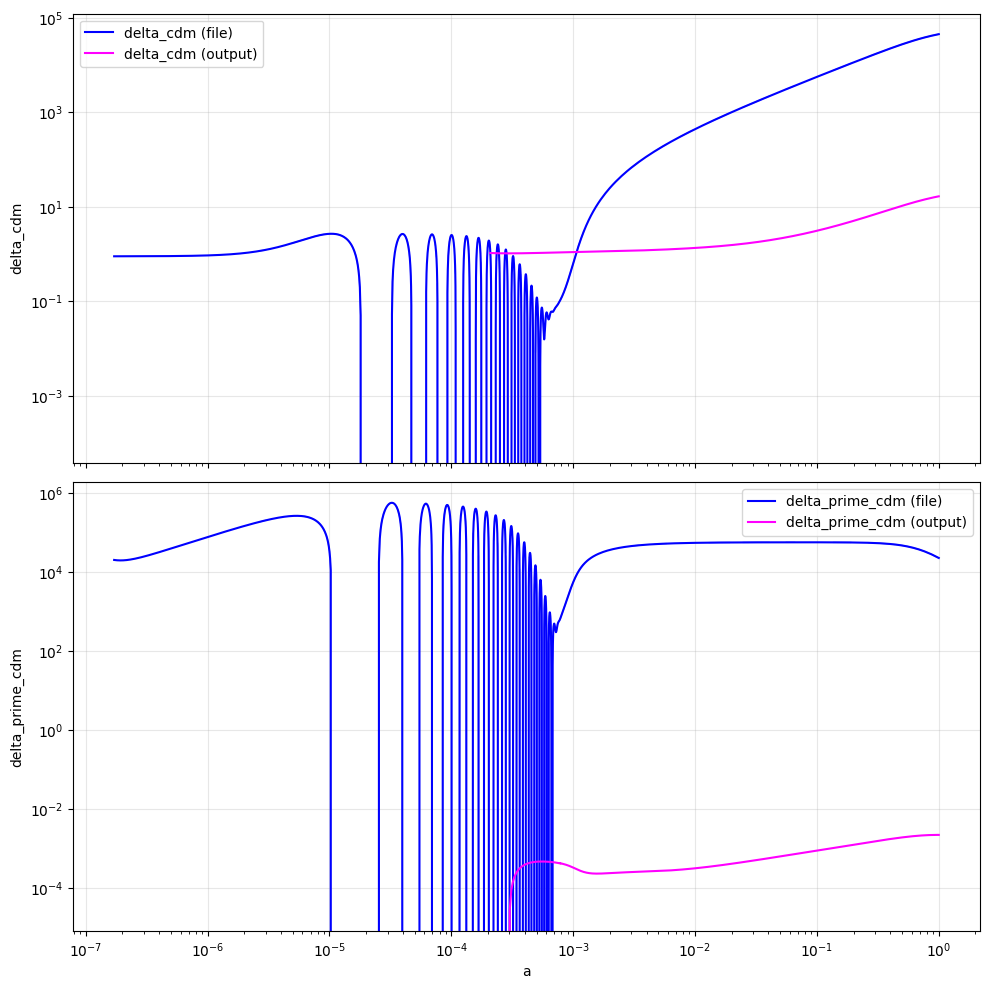

In [29]:

#plot with sns delta and delta_prime vs a
import seaborn as sns
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
sns.lineplot(data=df_k, x='a', y='delta_cdm', ax=axs[0], label='delta_cdm (file)', color='blue')
sns.lineplot(data=df_output, x='a', y='delta_cdm', ax=axs[0], label='delta_cdm (output)', color='magenta')
sns.lineplot(data=df_k, x='a', y='delta_prime_cdm_a', ax=axs[1], label='delta_prime_cdm (file)', color='blue')
sns.lineplot(data=df_output, x='a', y='delta_prime_cdm', ax=axs[1], label='delta_prime_cdm (output)', color='magenta')
axs[0].set_ylabel('delta_cdm')
axs[1].set_ylabel('delta_prime_cdm')
axs[1].set_xlabel('a')
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].grid(alpha=0.3)
axs[1].grid(alpha=0.3)
axs[1].legend()
plt.tight_layout()
plt.show()


### comparación con lo integrado numéricamente con lo de Luca

In [30]:
path = '/home/pedrorozin/scripts/class_public/delta_prime_cdm.txt' #file escrito con perturbations.c

#import the data as df with first column as 'a' and second column as 'delta_prime_cdm'

df = pd.read_csv(path, sep=' ', names=['delta_cdm', 'delta_prime_cdm', 'a', 'k', 'H'])

#print row with the first value of k greater or equal to 0.01
k_threshold = 0.01
df_filtered = df[df['k'] >= k_threshold]
df_filtered = df_filtered.sort_values(by='k')
df_filtered = df_filtered.reset_index(drop=True)
df_filtered.head()
k= df_filtered['k'].min()

df_k = df_filtered[df_filtered['k'] == df_filtered['k'].min()]
df_k.loc[:, 'delta_prime_cdm'] = -df_k['delta_prime_cdm'].astype(float) #paso todo a positivo (default es negativo)
df_k.loc[:, 'delta_cdm'] = -df_k['delta_cdm'].astype(float) #paso todo a positivo (default es negativo)

#add derivative respect to a
df_k = deriv_tau_to_a(df_k)

#sort by a
df_k = df_k.sort_values(by='a').reset_index(drop=True)

print(max(df_k['a'])) 
#len df
print(len(df_k['a']))
df_k.head()




1.0
1568


/tmp/ipykernel_783/768663952.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name + '_a'] = df[column_name] / (df['H'] * df['a'])


,delta_cdm,delta_prime_cdm,a,k,H,delta_prime_cdm_a
0,0.909609,0.001474,0.000014,0.011087,0.158387,667.826484
1,0.909609,0.001474,0.000014,0.011087,0.158387,667.826484
2,0.909609,0.001474,0.000014,0.011087,0.158387,667.825577
3,0.909609,0.001474,0.000014,0.011087,0.158387,667.826484
4,0.909609,0.001474,0.000014,0.011087,0.158387,667.826484


omega_b: 0.05, omega_cdm: 0.25, omega_m: 0.3, k: 0.001, A_s: 2e-09, h: 0.68, n_s: 0.965, tau_reio: 0.05430842, YHe: 0.2454
Omega_radiation: 9.045385269436243e-05, Omega_lambda: 0.6999095461473057
------
con estos parámetros y a0=0.01011272, el k_horizonte es: 0.8796844736599256 h/Mpc
------
delta_0: 20.18605
delta_prima_0: 2019.1574476390128
Initial conditions: a_0=0.01011272, delta_0=20.18605


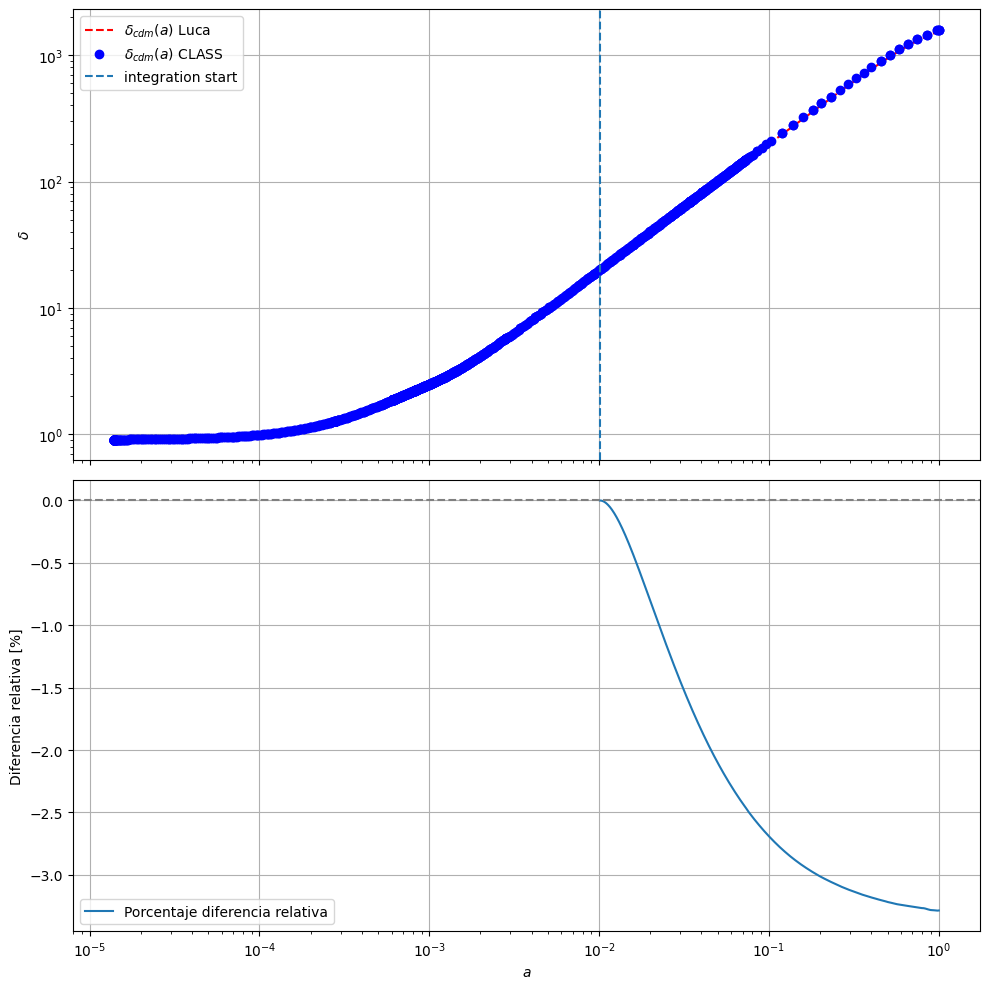

In [31]:
#get initial conditions with this df:
initial_index = np.where(df_k['a'] >= 1e-2)[0][0]  # first index where a >= threshold

#use read_ini_params to get the parameters
#read ini file parameters
ini_file_path = "/home/pedrorozin/scripts/class_public/test_delta_prime_gauge_newtonian.ini"
params = read_ini_params(ini_file_path)
# print(f"Parameters from ini file: {params}")
om_b = params['Omega_b']
om_cdm = params['Omega_cdm']
om_m = om_b + om_cdm
k = params['k_output_values']
A_s = params['A_s']
h = params['h']
n_s = params['n_s']
tau_reio = params['tau_reio']
YHe = params['YHe']
#generate M from CLASS to get Omega_radiation and Omega_lambda
M = common_settings(k=k, omega_cdm=om_cdm, A_s=A_s, h=h, ns=n_s, tau_reio=tau_reio, YHe=YHe)
# Imprimir los parámetros
print(f"omega_b: {om_b}, omega_cdm: {om_cdm}, omega_m: {om_m}, k: {k}, A_s: {A_s}, h: {h}, n_s: {n_s}, tau_reio: {tau_reio}, YHe: {YHe}")
#obtener Omega_radiation y Omega_lambda
om_r = M.Omega_r()
om_l = M.Omega_Lambda()
print(f"Omega_radiation: {om_r}, Omega_lambda: {om_l}")
print('------')


# condiciones iniciales
a_0 = df_k['a'][initial_index]
a_f = df_k['a'].iloc[-1]
delta_00 = df_k['delta_cdm'][initial_index]
delta_prima_00 = df_k['delta_prime_cdm_a'][initial_index]

k_horizont_value = k_horizont(a0=a_0, Om_m=om_m, Om_lambda=om_l, Om_r=om_r)
print(f'con estos parámetros y a0={a_0}, el k_horizonte es: {k_horizont_value} h/Mpc')
print('------')
print('delta_0:', delta_00)
print('delta_prima_0:', delta_prima_00)


# Integrar la ecuación diferencial para delta_cdm vs a
a_vec, delta_cdm = get_delta_cdm_vs_a((om_m, 0.8), delta_0=delta_00, delta_prima_0=delta_prima_00,
                                        a_0=a_0, a_f=1, method='RK45', atol=1e-10, rtol=1e-8, omr=om_r)
#print initial conditions of delta_cdm
print(f"Initial conditions: a_0={a_0}, delta_0={delta_cdm[0]}")

# Calcular la diferencia porcentual relativa
percent_diff = -percent_diff_vs_class(a_vec, delta_cdm, df_k['a'], df_k['delta_cdm'])

# plot resultados
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
# curvas
axs[0].plot(a_vec, delta_cdm, 'r--', label=r"$\delta_{cdm}(a)$ Luca")
axs[0].plot(df_k['a'], df_k['delta_cdm'],'o', label=r"$\delta_{cdm}(a)$ CLASS", color='blue')
axs[0].axvline(x=a_vec[0], ls='--', label='integration start')
axs[0].set_ylabel(r"$\delta$")
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].legend()
# axs[0].set_title("Comparación de integración de Luca y CLASS")
axs[0].grid(True)
# Segundo subplot: diferencias porcentuales
axs[1].plot(a_vec, percent_diff, label='Porcentaje diferencia relativa')
axs[1].axhline(0, color='gray', ls='--')
axs[1].set_xlabel('$a$')
axs[1].set_ylabel('Diferencia relativa [%]')
axs[1].set_xscale('log')
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.show()

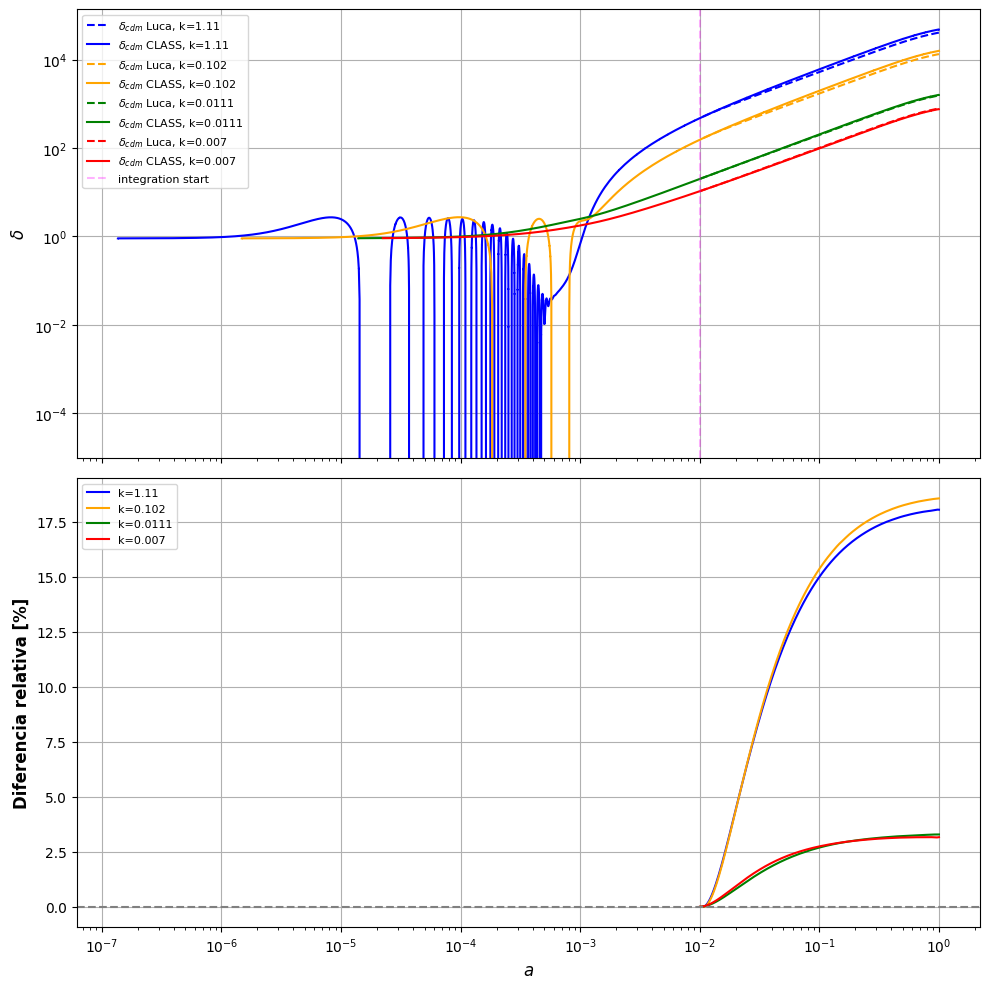

In [32]:
k_thresholds = [1.0, 0.1, 0.01, 0.006]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Parámetros cosmológicos
ini_file_path = "/home/pedrorozin/scripts/class_public/test_delta_prime_gauge_newtonian.ini"
params = read_ini_params(ini_file_path)
# print(f"Parameters from ini file: {params}")
om_b = params['Omega_b']
om_cdm = params['Omega_cdm']
om_m = om_b + om_cdm
k = params['k_output_values']
A_s = params['A_s']
h = params['h']
n_s = params['n_s']
tau_reio = params['tau_reio']
YHe = params['YHe']

#df:
df_file_path = '/home/pedrorozin/scripts/class_public/delta_prime_cdm.txt'
df = pd.read_csv(df_file_path, sep=' ', names=['delta_cdm', 'delta_prime_cdm', 'a', 'k', 'H'])

fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

for i, k_th in enumerate(k_thresholds):
    # filter by k >= k_th
    df_filtered = df[df['k'] >= k_th]
    if df_filtered.empty:
        print(f"No hay k >= {k_th}")
        continue

    k_sel = df_filtered['k'].min() #k selected en esta iteración
    df_k = df[df['k'] == k_sel].copy() #df con el k seleccionado
    # sort by a
    df_k = df_k.sort_values(by='a').reset_index(drop=True)
    # pasar a positivo
    df_k.loc[:, 'delta_prime_cdm'] = -df_k['delta_prime_cdm'].astype(float)
    df_k.loc[:, 'delta_cdm'] = -df_k['delta_cdm'].astype(float)
    # agregar derivada respecto a a
    df_k = deriv_tau_to_a(df_k)

    # initial conditions. en ppio están iguales para todos los k's
    initial_index = np.where(df_k['a'] >= 1e-2)[0][0]
    a_0 = df_k['a'][initial_index]
    a_f = df_k['a'].iloc[-1]
    delta_00 = df_k['delta_cdm'][initial_index]
    delta_prima_00 = df_k['delta_prime_cdm_a'][initial_index]

    # integración de luca
    a_vec, delta_cdm = get_delta_cdm_vs_a((om_m, 0.8), delta_0=delta_00, delta_prima_0=delta_prima_00,
                                          a_0=a_0, a_f=1, method='RK45', atol=1e-10, rtol=1e-8, omr=om_r)
    # dif porcentual
    percent_diff = abs(percent_diff_vs_class(a_vec, delta_cdm, df_k['a'], df_k['delta_cdm']))
    # Plot curvas
    axs[0].plot(a_vec, delta_cdm, '--', color=colors[i % len(colors)], label=fr"$\delta_{{cdm}}$ Luca, k={k_sel:.3g}")
    axs[0].plot(df_k['a'], df_k['delta_cdm'], '-', color=colors[i % len(colors)], label=fr"$\delta_{{cdm}}$ CLASS, k={k_sel:.3g}",
                 markersize=3)
    
    # Plot diferencia porcentual
    axs[1].plot(a_vec, percent_diff, color=colors[i % len(colors)], label=fr"k={k_sel:.3g}")

axs[0].axvline(x=a_vec[0], ls='--', color= 'magenta', alpha=0.3, label='integration start')
axs[0].set_ylabel(r"$\delta$", fontsize= 12, fontweight='bold')
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].legend(fontsize=8)
axs[0].grid(True)
axs[1].axhline(0, color='gray', ls='--')
axs[1].set_xlabel('$a$', fontsize= 12, fontweight='bold')
axs[1].set_ylabel('Diferencia relativa [%]', fontsize= 12, fontweight='bold')
axs[1].set_xscale('log')
axs[1].legend(fontsize=8)
axs[1].grid(True)
plt.tight_layout()
plt.show()

### Diferencia relativa entre delta_cdm y delta_m

In [33]:
path = '/home/pedrorozin/scripts/class_public/delta_prime_cdm.txt' #file escrito con perturbations.c

#import the data as df with first column as 'a' and second column as 'delta_prime_cdm'

df = pd.read_csv(path, sep=' ', names=['delta_cdm', 'delta_prime_cdm', 'delta_b', 'delta_prime_b', 'a', 'k', 'H'])
df.head()



,delta_cdm,delta_prime_cdm,delta_b,delta_prime_b,a,k,H
0,-0.902691,-0.016829,-0.902691,-0.016826,4.696919e-07,0.321755,4.596494
1,-0.902604,-0.025761,-0.902604,-0.025756,2.996558e-07,0.504188,7.202691
2,-0.902804,-0.011783,-0.902804,-0.011781,6.912142e-07,0.218718,3.124542
3,-0.902591,-0.027996,-0.902591,-0.027990,2.747651e-07,0.549840,7.854850
4,-0.902654,-0.019656,-0.902654,-0.019652,3.981810e-07,0.379495,5.421354


In [34]:
#filter by k >= 0.01
k_threshold = 0.2
df_filtered = df[df['k'] >= k_threshold]
df_filtered = df_filtered.sort_values(by='k')
df_filtered = df_filtered.reset_index(drop=True)
df_filtered.head()
k= df_filtered['k'].min()
df_k = df_filtered[df_filtered['k'] == df_filtered['k'].min()]
df_k.loc[:, 'delta_prime_cdm'] = -df_k['delta_prime_cdm'].astype(float) #paso todo a positivo (default es negativo)
df_k.loc[:, 'delta_cdm'] = -df_k['delta_cdm'].astype(float) #paso todo a positivo (default es negativo)
df_k.loc[:, 'delta_prime_b'] = -df_k['delta_prime_b'].astype(float) #paso todo a positivo (default es negativo)
df_k.loc[:, 'delta_b'] = -df_k['delta_b'].astype(float) #paso todo a positivo (default es negativo)
#sort by a
df_k = df_k.sort_values(by='a').reset_index(drop=True)
print(max(df_k['a'])) 
#len df
print(len(df_k['a']))
#add 'delta_m' and 'delta_prime_m' to df_k
df_k['delta_m'] = om_cdm/om_m * df_k['delta_cdm'] + om_b/om_m * df_k['delta_b']
df_k['delta_prime_m'] = om_cdm/om_m * df_k['delta_prime_cdm'] + om_b/om_m * df_k['delta_prime_b']
#regla de la cadena para pasar de tau a a
df_k = deriv_tau_to_a(df_k, column_name='delta_prime_cdm')
df_k = deriv_tau_to_a(df_k, column_name='delta_prime_m')
df_k =deriv_tau_to_a(df_k, column_name = 'delta_prime_b')
df_k.head()
display(df_k.head())

1.0
2386


,delta_cdm,delta_prime_cdm,delta_b,delta_prime_b,a,k,H,delta_m,delta_prime_m,delta_prime_cdm_a,delta_prime_m_a,delta_prime_b_a
0,0.902828,0.011093,0.902828,0.011091,7.388411e-07,0.204635,2.923359,0.902828,0.011093,5135.956019,5135.805549,5135.053199
1,0.902828,0.011093,0.902828,0.011091,7.388411e-07,0.204635,2.923359,0.902828,0.011093,5135.956019,5135.805549,5135.053199
2,0.902828,0.011093,0.902828,0.011091,7.388411e-07,0.204635,2.923359,0.902828,0.011093,5135.956019,5135.805549,5135.053199
3,0.902828,0.011093,0.902828,0.011091,7.388411e-07,0.204635,2.923359,0.902828,0.011093,5135.956019,5135.805549,5135.053199
4,0.902828,0.011093,0.902828,0.011091,7.388411e-07,0.204635,2.923359,0.902828,0.011093,5135.932870,5135.782400,5135.030049


In [35]:
#obtain parameters from ini file
ini_file_path = "/home/pedrorozin/scripts/class_public/test_delta_prime_gauge_newtonian.ini"
params = read_ini_params(ini_file_path)
om_b = params['Omega_b']
om_cdm = params['Omega_cdm']
om_m = om_b + om_cdm
# printear los parámetros
print(f"omega_b: {om_b}, omega_cdm: {om_cdm}, omega_m: {om_m}, k: {df_k['k'].iloc[0]}")

omega_b: 0.05, omega_cdm: 0.25, omega_m: 0.3, k: 0.2046351


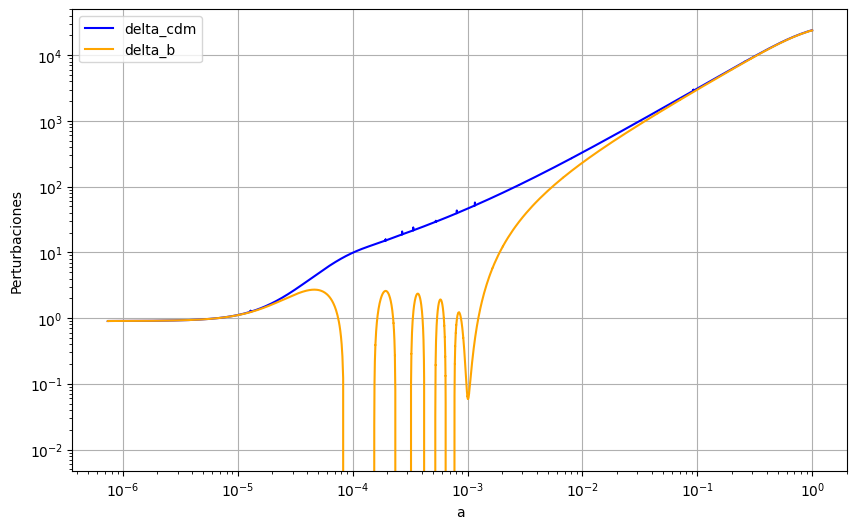

In [36]:
#plot delta_cdm and delta_b vs a
plt.figure(figsize=(10, 6))
plt.plot(df_k['a'], df_k['delta_cdm'], label='delta_cdm', color='blue')
plt.plot(df_k['a'], df_k['delta_b'], label='delta_b', color='orange')
plt.xlabel('a')
plt.ylabel('Perturbaciones')
plt.xscale('log')
plt.yscale('log')
# plt.title('Perturbaciones de delta_cdm y delta_b vs a')
plt.legend()
plt.grid()
plt.show()

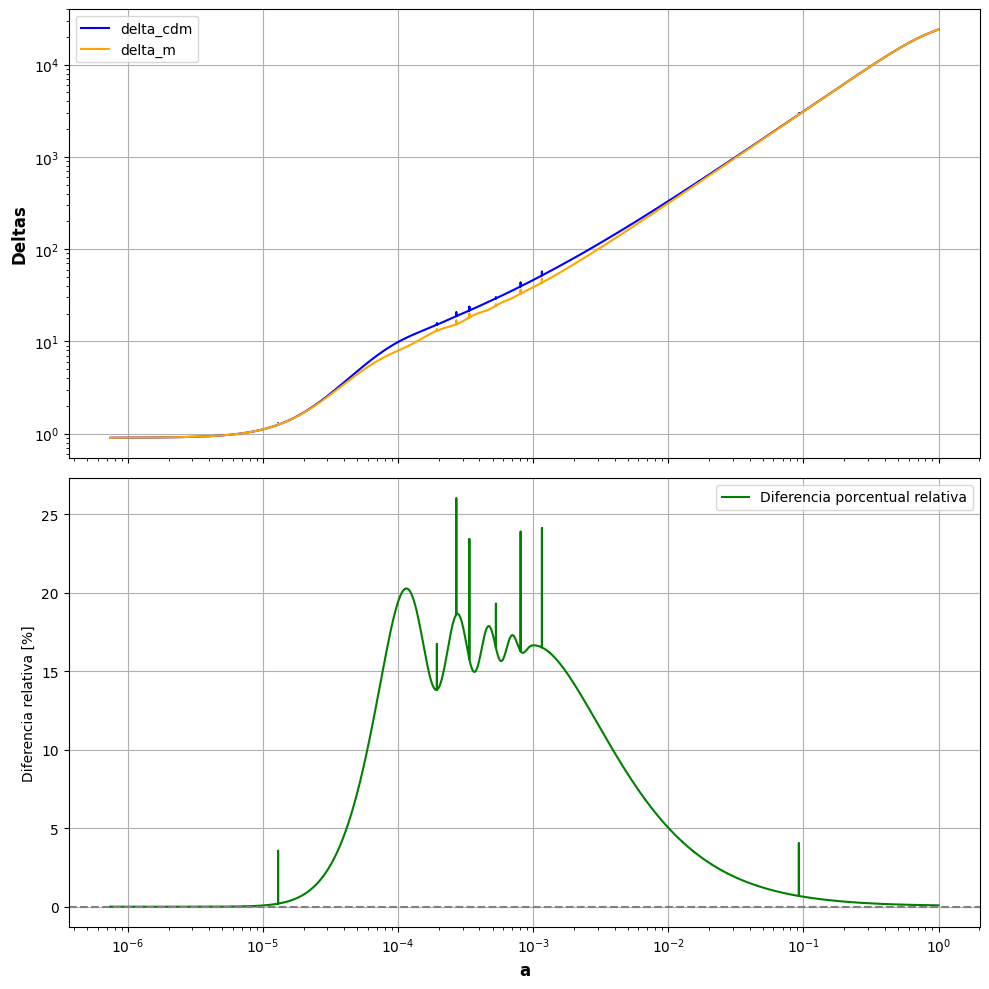

In [37]:
#plot diferencias porcentuales entre delta_cdm y delta_m
dif = abs(percent_diff_vs_class(df_k['a'], df_k['delta_cdm'], df_k['a'], df_k['delta_m']))
fig, axs = plt.subplots(2,1, figsize=(10, 10), sharex=True)
axs[0].plot(df_k['a'], df_k['delta_cdm'], label='delta_cdm', color='blue')
axs[0].plot(df_k['a'], df_k['delta_m'], label='delta_m', color='orange')
axs[0].set_ylabel('Deltas', fontsize=12, fontweight='bold')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
# axs[0].set_title('Perturbaciones de delta_cdm y delta_m vs a
axs[0].legend()
axs[0].grid()
axs[1].plot(df_k['a'], dif, label='Diferencia porcentual relativa', color='green')
axs[1].axhline(0, color='gray', ls='--')
axs[1].set_xlabel('a', fontsize=12, fontweight='bold')
axs[1].set_ylabel('Diferencia relativa [%]')
axs[1].set_xscale('log')
axs[1].legend()
axs[1].grid()
plt.tight_layout()
plt.show()

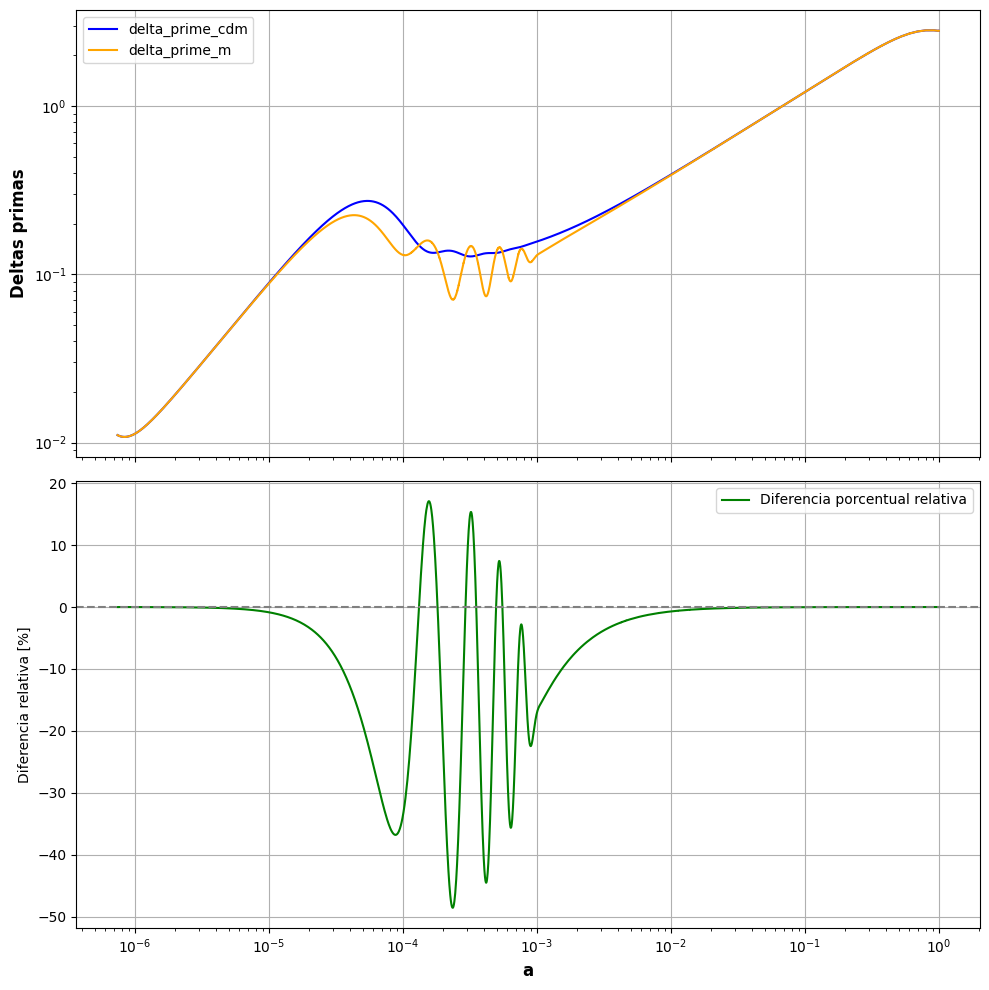

In [38]:
#diferencias porcentuales entre delta_prime_cdm y delta_prime_m
dif_prime = percent_diff_vs_class(df_k['a'], df_k['delta_prime_cdm'], df_k['a'], df_k['delta_prime_m'])
fig, axs = plt.subplots(2,1, figsize=(10, 10), sharex=True)
axs[0].plot(df_k['a'], df_k['delta_prime_cdm'], label='delta_prime_cdm', color='blue')
axs[0].plot(df_k['a'], df_k['delta_prime_m'], label='delta_prime_m', color='orange')
axs[0].set_ylabel('Deltas primas', fontsize=12, fontweight='bold')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
# axs[0].set_title('Perturbaciones de delta_prime_cdm y delta_prime_m vs a')
axs[0].legend()
axs[0].grid()
axs[1].plot(df_k['a'], dif_prime, label='Diferencia porcentual relativa', color='green')
axs[1].axhline(0, color='gray', ls='--')
axs[1].set_xlabel('a', fontsize=12, fontweight  ='bold')
axs[1].set_ylabel('Diferencia relativa [%]')
axs[1].set_xscale('log')
axs[1].legend()
axs[1].grid()
plt.tight_layout()
plt.show()

### Comparacion usando delta matter:

recordar que delta_prime_i es la derivada con respecto a tau de delta_i y delta_prime_i_a es la derivada con respecto a 'a'

In [39]:
path = '/home/pedrorozin/scripts/class_public/delta_prime_cdm.txt' #file escrito con perturbations.c

df = pd.read_csv(path, sep=' ', names=['delta_cdm', 'delta_prime_cdm', 'delta_b', 'delta_prime_b', 'a', 'k', 'H'])

k_threshold = 0.2
df_filtered = df[df['k'] >= k_threshold]
df_filtered = df_filtered.sort_values(by='k')
df_filtered = df_filtered.reset_index(drop=True)
df_filtered.head()
k= df_filtered['k'].min()
df_k = df_filtered[df_filtered['k'] == df_filtered['k'].min()]
df_k.loc[:, 'delta_prime_cdm'] = -df_k['delta_prime_cdm'].astype(float) #paso todo a positivo (default es negativo)
df_k.loc[:, 'delta_cdm'] = -df_k['delta_cdm'].astype(float) #paso todo a positivo (default es negativo)
df_k.loc[:, 'delta_prime_b'] = -df_k['delta_prime_b'].astype(float) #paso todo a positivo (default es negativo)
df_k.loc[:, 'delta_b'] = -df_k['delta_b'].astype(float) #paso todo a positivo (default es negativo)
#sort by a
df_k = df_k.sort_values(by='a').reset_index(drop=True)
# print(max(df_k['a'])) 
#len df
# print(len(df_k['a']))
#add 'delta_m' and 'delta_prime_m' to df_k
df_k['delta_m'] = om_cdm/om_m * df_k['delta_cdm'] + om_b/om_m * df_k['delta_b']
df_k['delta_prime_m'] = om_cdm/om_m * df_k['delta_prime_cdm'] + om_b/om_m * df_k['delta_prime_b']
#regla de la cadena para pasar de tau a a
df_k = deriv_tau_to_a(df_k, column_name='delta_prime_cdm')
df_k = deriv_tau_to_a(df_k, column_name='delta_prime_m')
df_k =deriv_tau_to_a(df_k, column_name = 'delta_prime_b')
# display(df_k.head())

In [40]:
#condiciones iniciales
initial_index = np.where(df_k['a'] >= 1e-3)[0][0]  # first index where a >= 1e-2
a_0 = df_k['a'][initial_index]
a_f = df_k['a'].iloc[-1]
delta_00 = df_k['delta_m'][initial_index]
delta_prima_00 = df_k['delta_prime_m_a'][initial_index]
print('delta_0:', delta_00)
print('delta_prima_0:', delta_prima_00)

delta_0: 38.55942030166667
delta_prima_0: 29012.778780623594


el k utilizado es: 0.2046351


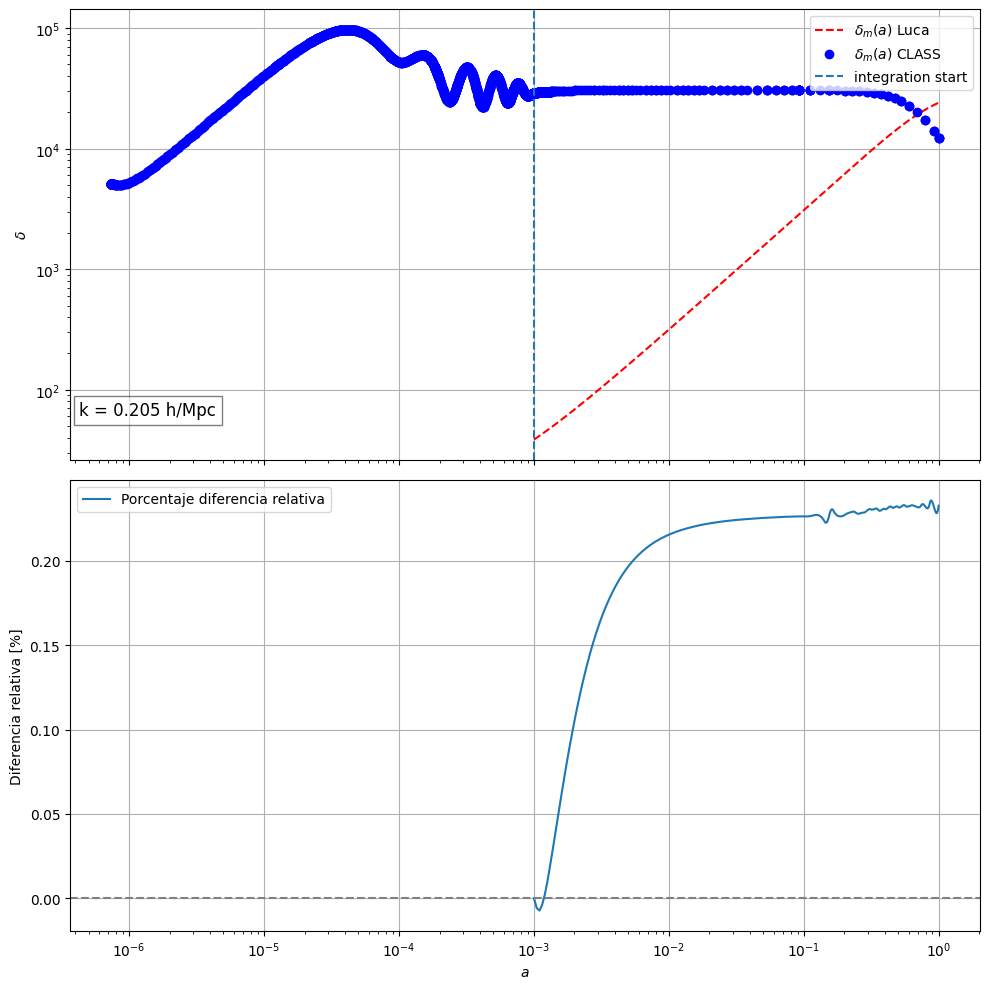

In [41]:

ini_file_path = "/home/pedrorozin/scripts/class_public/test_delta_prime_gauge_newtonian.ini"
params = read_ini_params(ini_file_path)
# print(f"Parameters from ini file: {params}")
om_b = params['Omega_b']
om_cdm = params['Omega_cdm']
om_m = om_b + om_cdm
_k = params['k_output_values']
A_s = params['A_s']
h = params['h']
n_s = params['n_s']
tau_reio = params['tau_reio']
YHe = params['YHe']
k = df_k['k'].iloc[0]
#generate M from CLASS to get Omega_radiation and Omega_lambda
M = common_settings(k=k, omega_cdm=om_cdm, A_s=A_s, h=h, ns=n_s, tau_reio=tau_reio, YHe=YHe) #puse el k del threshold, pero es lo mismo
# get Omega_radiation and Omega_lambda
om_r = M.Omega_r()
om_l = M.Omega_Lambda()
# print(f"Omega_radiation: {om_r}, Omega_lambda: {om_l}")
# print(1- om_m - om_r) #debería ser Omega_lambda
#integrar ecuacion de luca con las condiciones iniciales
a_vec, delta_m = get_delta_cdm_vs_a((om_m, 0.8), delta_0=delta_00, delta_prima_0=delta_prima_00,
                                     a_0=a_0, a_f=a_f, method='RK45', atol=1e-10, rtol=1e-8, omr=om_r)
# calcular la diferencia porcentual relativa
percent_diff = -percent_diff_vs_class(a_vec, delta_m, df_k['a'], df_k['delta_m'])
# plot resultados
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
# curvas
axs[0].plot(a_vec, delta_m, 'r--', label=r"$\delta_{m}(a)$ Luca")
axs[0].plot(df_k['a'], df_k['delta_prime_m_a'], 'o', label=r"$\delta_{m}(a)$ CLASS", color='blue')
axs[0].axvline(x=a_vec[0], ls='--', label='integration start')
axs[0].set_ylabel(r"$\delta$")
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].legend()
# axs[0].set_title("Comparación de integración de Luca y CLASS")
axs[0].grid(True)
#text in axs[0] with the k used
axs[0].text(0.01, 0.1, f'k = {k:.3g} h/Mpc', transform=axs[0].transAxes,
            fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
# Segundo subplot: diferencias porcentuales
axs[1].plot(a_vec, percent_diff, label='Porcentaje diferencia relativa')
axs[1].axhline(0, color='gray', ls='--')
axs[1].set_xlabel('$a$')
axs[1].set_ylabel('Diferencia relativa [%]')
axs[1].set_xscale('log')
axs[1].legend()
axs[1].grid(True)
print(f'el k utilizado es: {k}')
plt.tight_layout()
plt.show()

Processing k=1.11
delta_0: 324.2684333333333
delta_prima_0: 62038.08691140894
---------
Processing k=0.102
delta_0: 106.20081666666668
delta_prima_0: 20346.338131756173
---------
Processing k=0.205
delta_0: 171.32550333333333
delta_prima_0: 30798.660863299952
---------
Processing k=0.0111
delta_0: 11.47085
delta_prima_0: 2065.4780602064898
---------
Processing k=0.007
delta_0: 5.953113666666667
delta_prima_0: 996.5679455600637
---------
------
------
con estos parámetros y a0=0.005, el k_horizonte es: 1.2634590960094252 h/Mpc
------
------


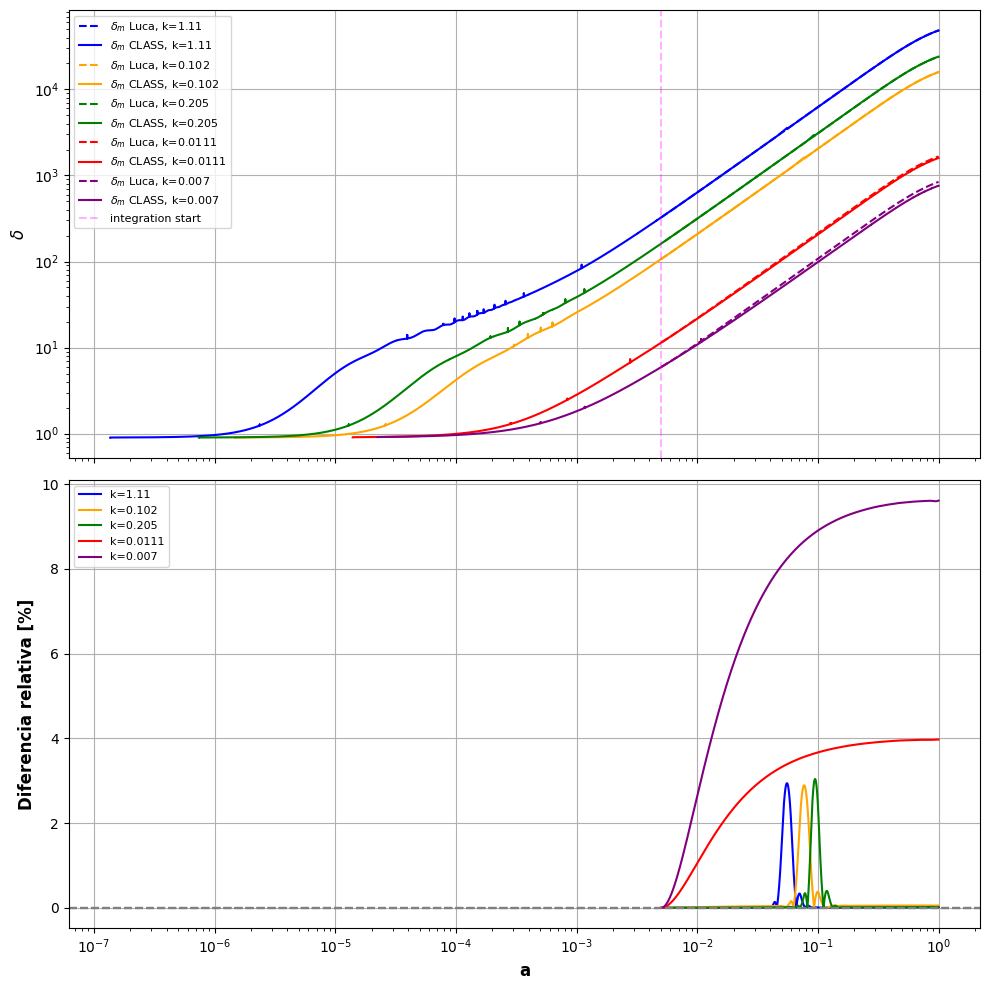

In [42]:
#diferencia porcentuales para distintos k's
k_thresholds = [1.0, 0.1, 0.2, 0.01, 0.006]
# k_thresholds = [1.0, k_horizont_value + k_horizont_value/10,k_horizont_value, k_horizont_value - k_horizont_value/10]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
# Parámetros cosmológicos
ini_file_path = "/home/pedrorozin/scripts/class_public/test_delta_prime_gauge_newtonian.ini"
params = read_ini_params(ini_file_path)
# print(f"Parameters from ini file: {params}")
om_b = params['Omega_b']
om_cdm = params['Omega_cdm']
om_m = om_b + om_cdm
k = params['k_output_values']
A_s = params['A_s']
h = params['h']
n_s = params['n_s']
tau_reio = params['tau_reio']
YHe = params['YHe']
#generate M from CLASS to get Omega_radiation and Omega_lambda
M = common_settings(k=k, omega_cdm=om_cdm, A_s=A_s, h=h, ns=n_s, tau_reio=tau_reio, YHe=YHe)
# Imprimir los parámetros
# print(f"omega_b: {om_b}, omega_cdm: {om_cdm}, omega_m: {om_m}, k: {k}, A_s: {A_s}, h: {h}, n_s: {n_s}, tau_reio: {tau_reio}, YHe: {YHe}")
#obtener Omega_radiation y Omega_lambda
om_r = M.Omega_r()
om_l = M.Omega_Lambda()


#df:
df_file_path = '/home/pedrorozin/scripts/class_public/delta_prime_cdm.txt'
df = pd.read_csv(df_file_path, sep=' ', names=['delta_cdm', 'delta_prime_cdm', 'delta_b', 'delta_prime_b', 'a', 'k', 'H'])
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
for i, k_th in enumerate(k_thresholds):
    # filter by k >= k_th
    df_filtered = df[df['k'] >= k_th]
    if df_filtered.empty:
        print(f"No hay k >= {k_th}")
        continue

    k_sel = df_filtered['k'].min()  # k selected en esta iteración
    print(f"Processing k={k_sel:.3g}")
    df_k = df[df['k'] == k_sel].copy()  # df con el k seleccionado
    # sort by a
    df_k = df_k.sort_values(by='a').reset_index(drop=True)
    # pasar a positivo
    df_k.loc[:, 'delta_prime_cdm'] = -df_k['delta_prime_cdm'].astype(float)
    df_k.loc[:, 'delta_cdm'] = -df_k['delta_cdm'].astype(float)
    df_k.loc[:, 'delta_prime_b'] = -df_k['delta_prime_b'].astype(float)
    df_k.loc[:, 'delta_b'] = -df_k['delta_b'].astype(float)
    # agregar delta_m y delta_prime_m
    df_k['delta_m'] = om_cdm / om_m * df_k['delta_cdm'] + om_b / om_m * df_k['delta_b']
    df_k['delta_prime_m'] = om_cdm / om_m * df_k['delta_prime_cdm'] + om_b / om_m * df_k['delta_prime_b']
    # agregar derivada respecto a a
    df_k = deriv_tau_to_a(df_k, column_name='delta_prime_cdm')
    df_k = deriv_tau_to_a(df_k, column_name='delta_prime_m')
    df_k = deriv_tau_to_a(df_k, column_name = 'delta_prime_b')

    # initial conditions. en ppio están iguales para todos los k's
    initial_index = np.where(df_k['a'] >= 5*1e-03)[0][0]
    a_0 = df_k['a'][initial_index]
    a_f = df_k['a'].iloc[-1]
    delta_00 = df_k['delta_m'][initial_index]
    delta_prima_00 = df_k['delta_prime_m_a'][initial_index]
    print('delta_0:', delta_00)
    print('delta_prima_0:', delta_prima_00)
    # integración de luca
    a_vec, delta_m = get_delta_cdm_vs_a((om_m, 0.8), delta_0=delta_00, delta_prima_0=delta_prima_00,
                                         a_0=a_0, a_f=1, method='RK45', atol=1e-10, rtol=1e-8, omr=om_r)
    # dif porcentual
    percent_diff = abs(percent_diff_vs_class(a_vec, delta_m, df_k['a'], df_k['delta_m']))
    # Plot curvas
    axs[0].plot(a_vec, delta_m, '--', color=colors[i % len(colors)], label=fr"$\delta_{{m}}$ Luca, k={k_sel:.3g}")
    axs[0].plot(df_k['a'], df_k['delta_m'], '-', color=colors[i % len(colors)],
                 label=fr"$\delta_{{m}}$ CLASS, k={k_sel:.3g}",
                 markersize=3)
    # Plot diferencia porcentual
    axs[1].plot(a_vec, percent_diff, color=colors[i % len(colors)], label=fr"k={k_sel:.3g}")
    axs[0].grid(True)
    axs[1].axhline(0, color='gray', ls='--')
    
    axs[1].grid(True)
    print('---------')
axs[0].axvline(x=a_vec[0], ls='--', color='magenta', alpha=0.3, label='integration start')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')
axs[0].set_ylabel(r"$\delta$", fontsize=12, fontweight='bold')
axs[1].set_ylabel('Diferencia relativa [%]', fontsize=12, fontweight='bold')
axs[1].set_xlabel('a', fontsize=12, fontweight='bold')
axs[1].legend(fontsize=8)
axs[0].legend(fontsize=8)
k_horizont_value = k_horizont(a0=a_0, Om_m=om_m, Om_lambda=om_l, Om_r=om_r)
print('------')
print('------')
print(f'con estos parámetros y a0={a_0:.3f}, el k_horizonte es: {k_horizont_value} h/Mpc')
print('------')
print('------')
plt.tight_layout()
plt.show()

In [43]:
len(list(df[df['k']>= 0.08]['k'].unique()))

56

### $f\sigma_8(a, \vec{r}) = \frac{\sigma_8}{\hat{\delta}_m(1, \vec{k})} \, a \, \hat{\delta}_m'(a, \vec{k})$

In [45]:
#compute fsigma8:
def _Hh(params, a, omr):
    Om_m_0, s8 = params
    Om_L = 1 - Om_m_0 - omr
    return np.sqrt(Om_L + Om_m_0 / a**3 + omr / a**4)

def _Hh_p(params, a, omr):
    Om_m_0, s8 = params
    Om_L = 1 - Om_m_0 - omr
    num = (3 * Om_m_0 / a**4 + 4 * omr / a**5)
    den = 2 * np.sqrt(Om_L + Om_m_0 / a**3 + omr / a**4)
    return -num / den

def compute_fsigma8(params, delta_0, delta_prima_0, a_0, a_f, sigma8, omr, n_points=2000):
    a_vec = np.linspace(a_0, a_f, n_points)
    def F(a, X):
        f1 = X[1]
        term1 = X[0] * 3 * params[0] / (2 * (_Hh(params, a, omr) ** 2) * (a ** 5))
        term2 = -X[1] * ((3 / a) + (_Hh_p(params, a, omr) / _Hh(params, a, omr)))
        f2 = term1 + term2
        return np.array([f1, f2])
    out = solve_ivp(
        fun=F,
        t_span=[a_0, a_f],
        y0=np.array([delta_0, delta_prima_0]),
        t_eval=a_vec,
        method='RK45',
        atol=1e-10,
        rtol=1e-8
    )
    delta_m = out.y[0]
    delta_m_prime = out.y[1]
    delta_m_today = delta_m[-1]
    fsigma8 = sigma8 * a_vec * delta_m_prime / delta_m_today
    return a_vec, fsigma8

def compute_fsigma8_output(delta, delta_prime, a, sigma8):
    """
    Compute fsigma8 from delta and delta_prime arrays.
    Args:
        delta (array-like): Array of delta values.
        delta_prime (array-like): Array of delta_prime values.
        a (array-like): Array of scale factors.
        sigma8 (float): Normalization factor, default is 0.8.
    Returns:
        array: fsigma8 values.
    """
    delta_today = delta[-1]
    return sigma8 * a * delta_prime / delta_today

/tmp/ipykernel_783/1307177431.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k['delta_m'] = om_cdm / om_m * df_k['delta_cdm'] + om_b / om_m * df_k['delta_b']
/tmp/ipykernel_783/768663952.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name + '_a'] = df[column_name] / (df['H'] * df['a'])


1.0
3418


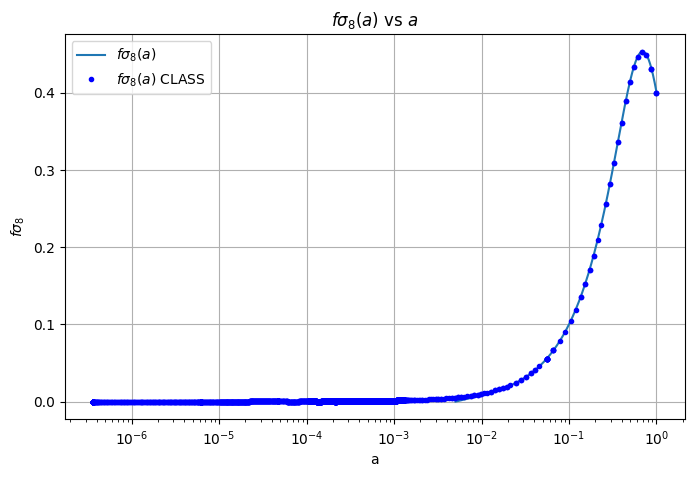

In [46]:


path = '/home/pedrorozin/scripts/class_public/delta_prime_cdm.txt' #file escrito con perturbations.c

#import the data as df with first column as 'a' and second column as 'delta_prime_cdm'

df = pd.read_csv(df_file_path, sep=' ', names=['delta_cdm', 'delta_prime_cdm', 'delta_b', 'delta_prime_b', 'a', 'k', 'H'])

#print row with the first value of k greater or equal to algo
k_threshold = 0.4
df_filtered = df[df['k'] >= k_threshold]
df_filtered = df_filtered.sort_values(by='k')
df_filtered = df_filtered.reset_index(drop=True)
df_filtered.head()
k= df_filtered['k'].min()

df_k = df_filtered[df_filtered['k'] == df_filtered['k'].min()]
df_k.loc[:, 'delta_prime_cdm'] = -df_k['delta_prime_cdm'].astype(float) #paso todo a positivo (default es negativo)
df_k.loc[:, 'delta_cdm'] = -df_k['delta_cdm'].astype(float) #paso todo a positivo (default es negativo)
df_k['delta_m'] = om_cdm / om_m * df_k['delta_cdm'] + om_b / om_m * df_k['delta_b']


#add derivative respect to a
df_k = deriv_tau_to_a(df_k)

#sort by a
df_k = df_k.sort_values(by='a').reset_index(drop=True)

print(max(df_k['a'])) 
#len df
print(len(df_k['a']))
df_k.head()

ini_file_path = "/home/pedrorozin/scripts/class_public/test_delta_prime_gauge_newtonian.ini"
params = read_ini_params(ini_file_path)
# print(f"Parameters from ini file: {params}")
om_b = params['Omega_b']
om_cdm = params['Omega_cdm']
om_m = om_b + om_cdm
k = params['k_output_values']
A_s = params['A_s']
h = params['h']
n_s = params['n_s']
tau_reio = params['tau_reio']
YHe = params['YHe']
M = common_settings(k=k, omega_cdm=om_cdm, A_s=A_s, h=h, ns=n_s, tau_reio=tau_reio, YHe=YHe)
#get sigma8 from M
sigma8= get_sigma8(M)
params_integracion = (om_m, sigma8)
Om_r = M.Omega_r()



a_vec, fsigma8 = compute_fsigma8(params_integracion, delta_0, delta_prima_0, a_0, a_f, sigma8, omr=Om_r)
a_output = np.array(df_k['a'])
df_k['delta_m'] = om_cdm / om_m * df_k['delta_cdm'] + om_b / om_m * df_k['delta_b']
df_k['delta_prime_m'] = om_cdm / om_m * df_k['delta_prime_cdm'] + om_b / om_m * df_k['delta_prime_b']
df_k = deriv_tau_to_a(df_k, column_name='delta_prime_m')
delta_m_output = np.array(df_k['delta_m'])
delta_m_prime_output = np.array(df_k['delta_prime_m_a'])

fs8_output = compute_fsigma8_output(delta_m_output, delta_m_prime_output, a_output, sigma8=sigma8)


#plot fsigma8 vs a
plt.figure(figsize=(8,5))
plt.plot(a_vec, fsigma8, label=r"$f\sigma_8(a)$")
plt.plot(a_output, fs8_output, 'o', label=r"$f\sigma_8(a)$ CLASS", color='blue', markersize=3)
plt.xlabel('a')
plt.ylabel(r"$f\sigma_8$")
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.title(r"$f\sigma_8(a)$ vs $a$")
plt.show()




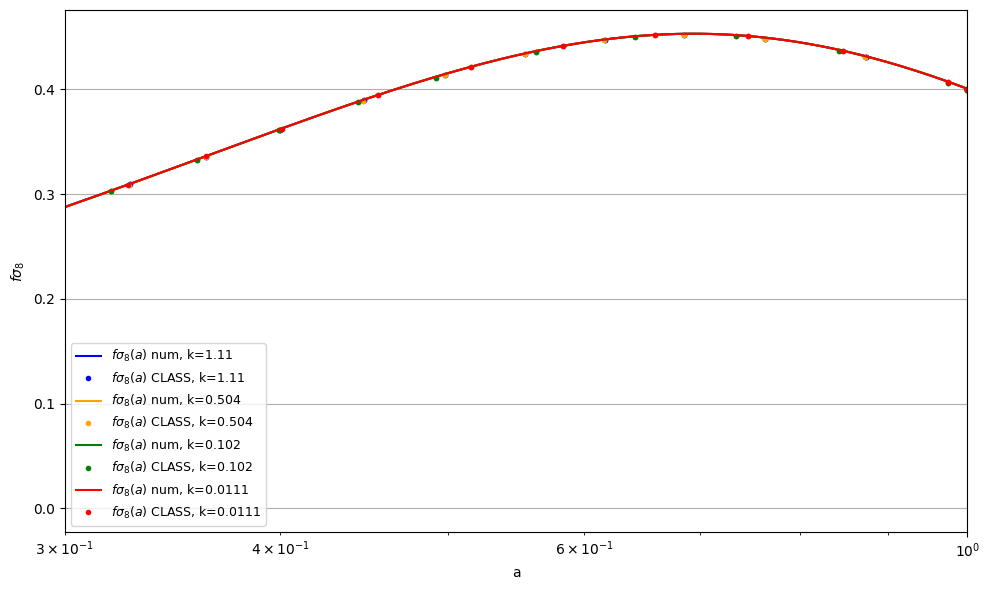

In [47]:
#same for differents k's

k_thresholds= [1,.5,.1,.01]
# k_thresholds = [1.0, 0.4, 0.2, 0.01]  # Ajusta los valores de k que quieras analizar
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

plt.figure(figsize=(10, 6))

for i, k_th in enumerate(k_thresholds):
#filtro
    df_filtered = df[df['k'] >= k_th]
    if df_filtered.empty:
        print(f"No hay k >= {k_th}")
        continue
    k_sel = df_filtered['k'].min()
    df_k = df[df['k'] == k_sel].copy()
    df_k = df_k.sort_values(by='a').reset_index(drop=True)
    df_k.loc[:, 'delta_prime_cdm'] = -df_k['delta_prime_cdm'].astype(float)
    df_k.loc[:, 'delta_cdm'] = -df_k['delta_cdm'].astype(float)
    df_k['delta_m'] = om_cdm / om_m * df_k['delta_cdm'] + om_b / om_m * df_k['delta_b']
    df_k['delta_prime_m'] = om_cdm / om_m * df_k['delta_prime_cdm'] + om_b / om_m * df_k['delta_prime_b']
    df_k = deriv_tau_to_a(df_k, 'delta_prime_m')
    df_k = deriv_tau_to_a(df_k)
    a_output = np.array(df_k['a'])
    delta_m_output = np.array(df_k['delta_m'])
    delta_m_prime_output = np.array(df_k['delta_prime_m_a'])

    initial_index = np.where(df_k['a'] >= 1e-2)[0][0]
    a_0 = df_k['a'][initial_index]
    a_f = df_k['a'].iloc[-1]
    delta_0 = df_k['delta_m'][initial_index]
    delta_prima_0 = df_k['delta_prime_m'][initial_index]
    a_vec, fsigma8 = compute_fsigma8(params_integracion, delta_0, delta_prima_0, a_0, a_f, sigma8, omr=Om_r)
    fs8_output = compute_fsigma8_output(delta_m_output, delta_m_prime_output, a_output, sigma8=sigma8)

    plt.plot(a_vec, fsigma8, color=colors[i % len(colors)], label=fr"$f\sigma_8(a)$ num, k={k_sel:.3g}")
    plt.plot(a_output, fs8_output, 'o', color=colors[i % len(colors)], markersize=3, label=fr"$f\sigma_8(a)$ CLASS, k={k_sel:.3g}")

plt.xlabel('a')
plt.ylabel(r"$f\sigma_8$")
plt.xscale('log')
plt.legend(fontsize=9)
plt.xlim(.3, 1)
plt.grid(True)
plt.tight_layout()
plt.show()